In [147]:
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
import json
import os
import re
import math
import matplotlib.ticker as tck
import glob
import statsmodels.api as sm

Loading files

In [ ]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
download = pd.read_csv(saving_path +'/all.csv', index_col=None)
download_closeby = pd.read_csv(saving_path +'/closeby_beads.csv', index_col=None)
download_faraway = pd.read_csv(saving_path +'/faraway_beads.csv', index_col=None)

## GLS model

In [73]:
alpha = 0.05
def GLS_g(data,ax, color):
    x= data['gradient'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    #print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions
    y_predictedGLS = np.exp(y_predictedGLS_log)  # Transform back from log scale

    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI,
                         #color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


In [74]:
from scipy.optimize import curve_fit

def fitting(ax,x_data, y_data,color_type,marker_type):
    
    def logistic_func(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    
    k_guess = 0.1  # initial slope estimate, a smaller value usually works
    L_guess = np.max(y_data) 
    k_guess = 0.1
    x0_guess = 2500
    params, _ = curve_fit(logistic_func, x_data, y_data,p0=[L_guess, k_guess, x0_guess], maxfev=10000)
    L, k, x0 = params

    # Display the fitted parameters
    print(f'Fitted parameters: L = {L:.3f}, k = {k:.3f}, x0 = {x0:.3f}')

    # Plot the data and the fitted logistic curve
    ax.scatter(x_data, y_data, label='Data', s=35,c=color_type, marker=marker_type)
    #ax.plot(x_data, logistic_func(x_data, *params), label=f'Logistic fit: L={L:.3f}, k={k:.3f}, x0={x0:.3f}', color=color_type)



Plotting G

Kernel Ridge Regression

Continuous

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel(x, y, ax,alpha, color, marker):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped) 
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color, marker=marker,s=50)
    
    #ax.boxplot(x_reshaped, y_reshaped, label='Original Data')

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color, label='Kernel Fit', linewidth=3)


Continous plot by distance

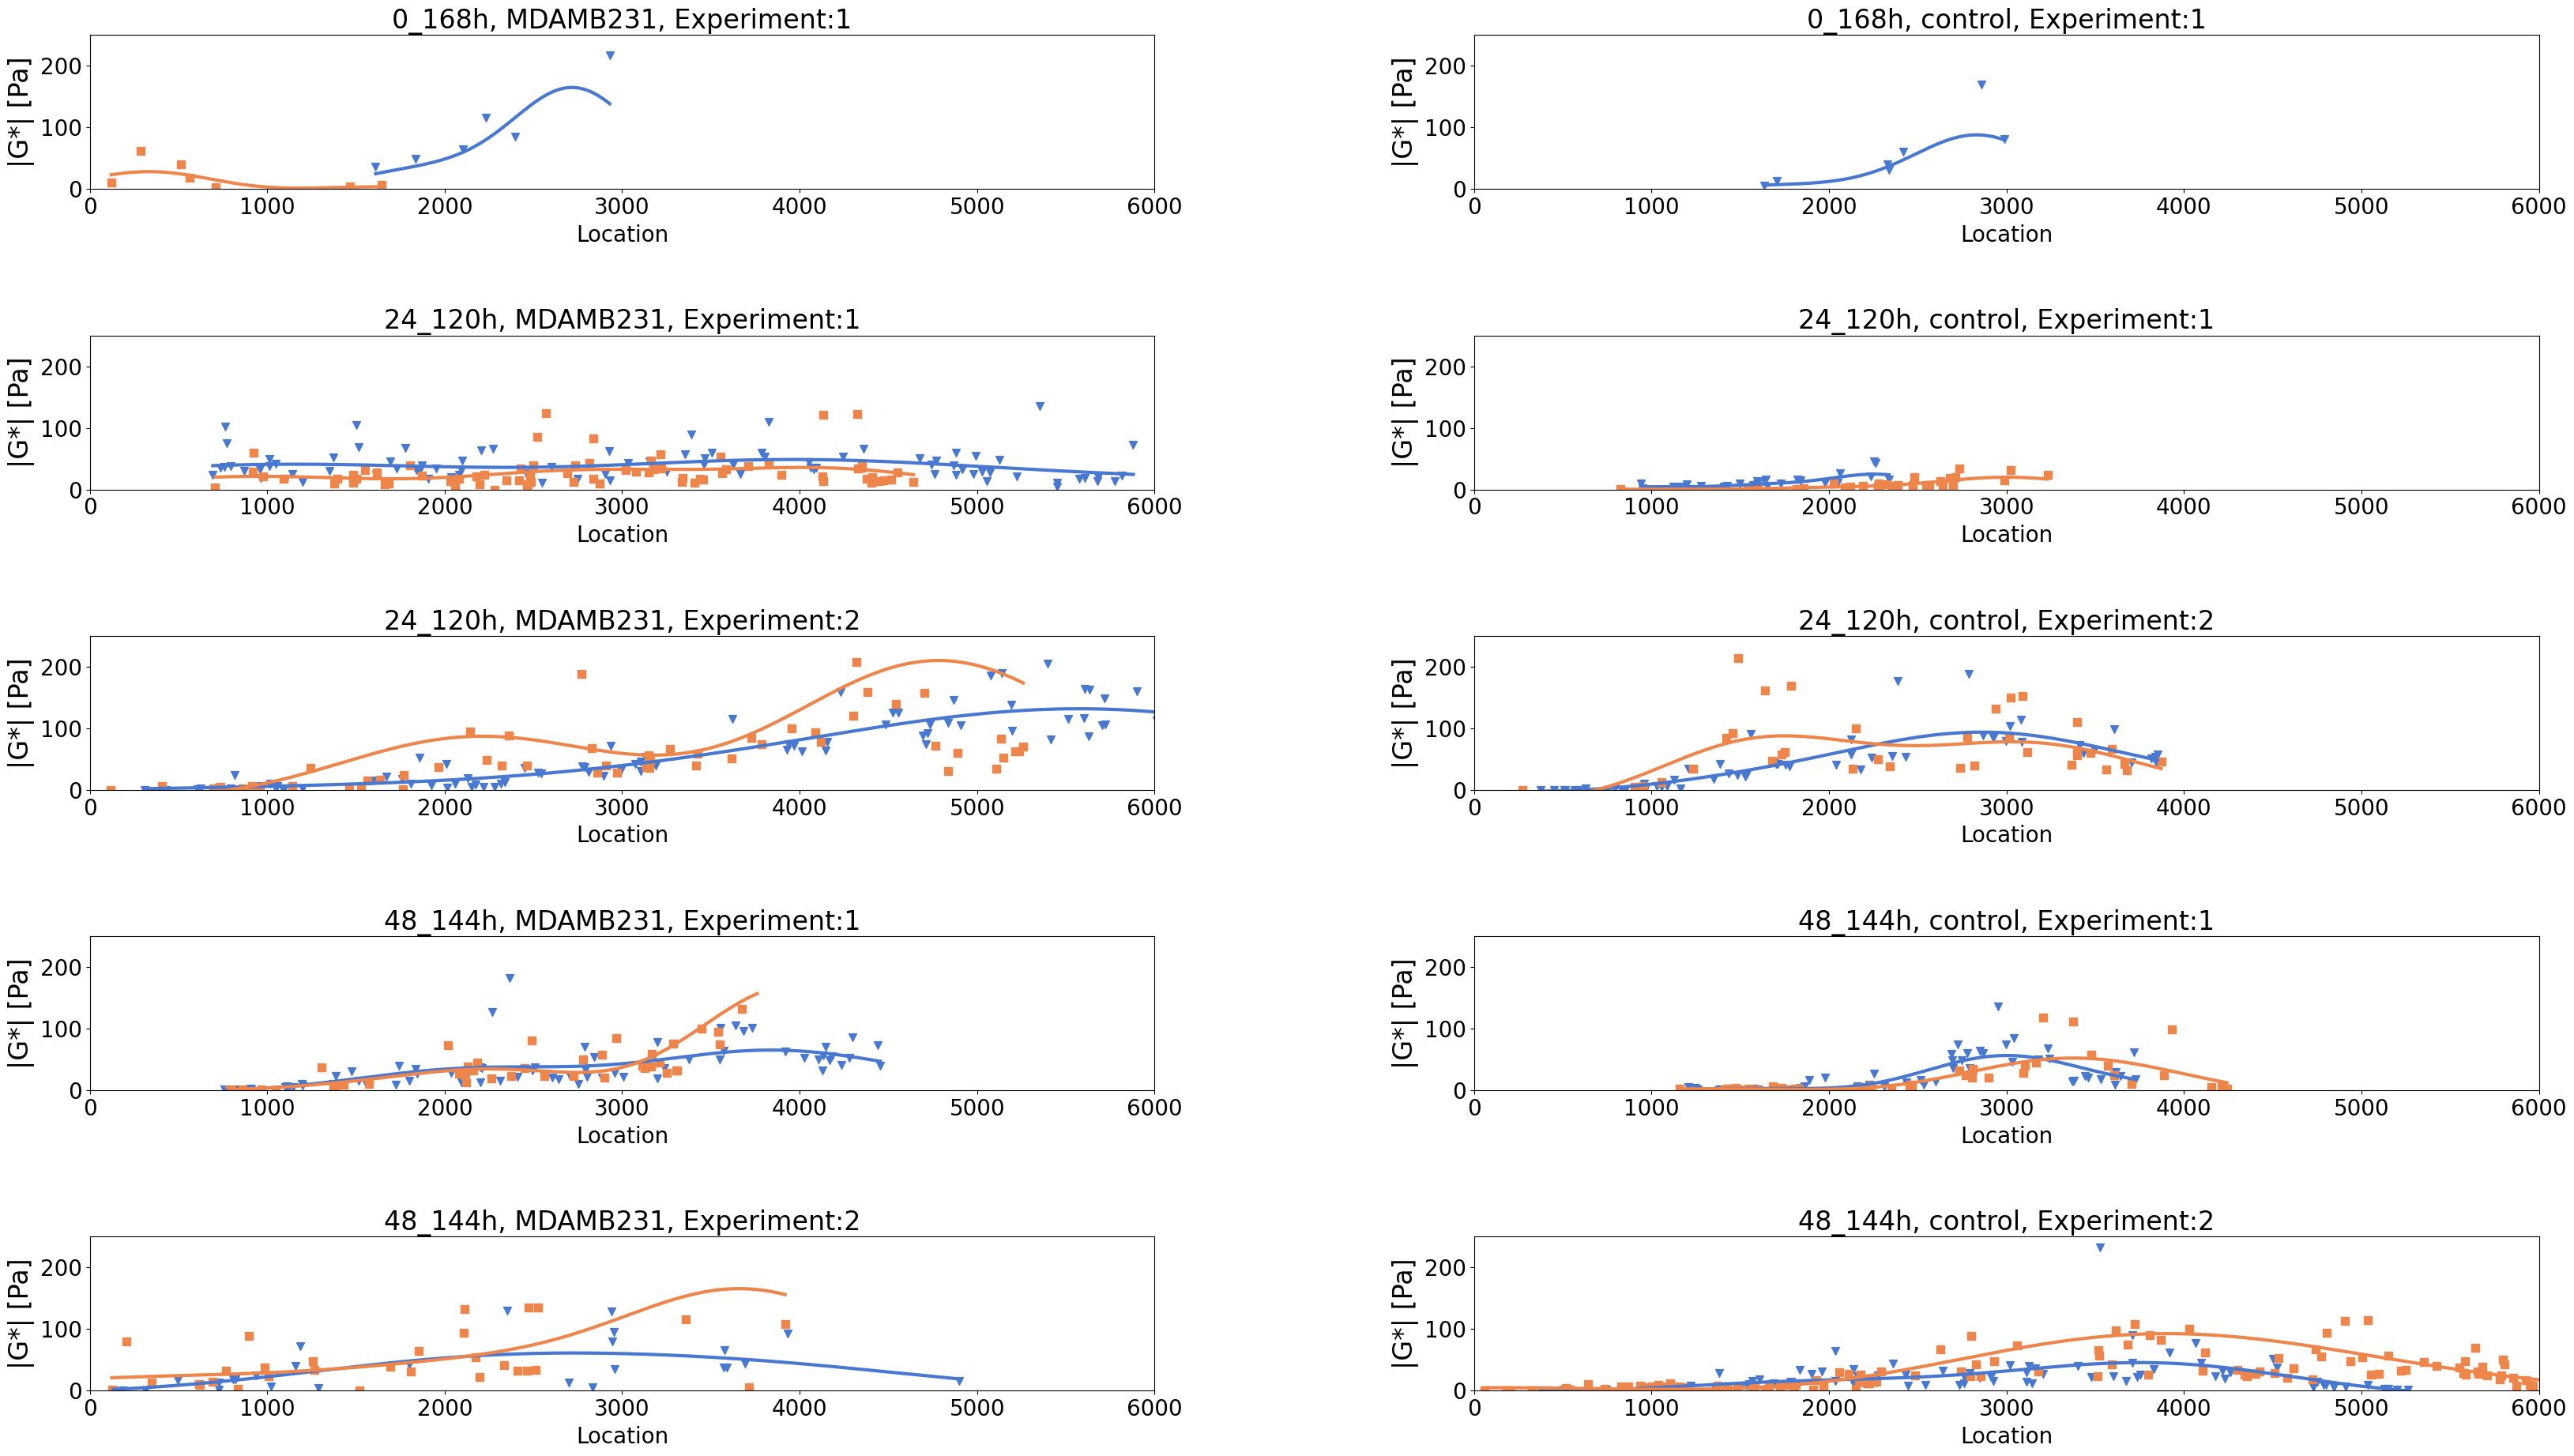

In [76]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['G_abs'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 250)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)
def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


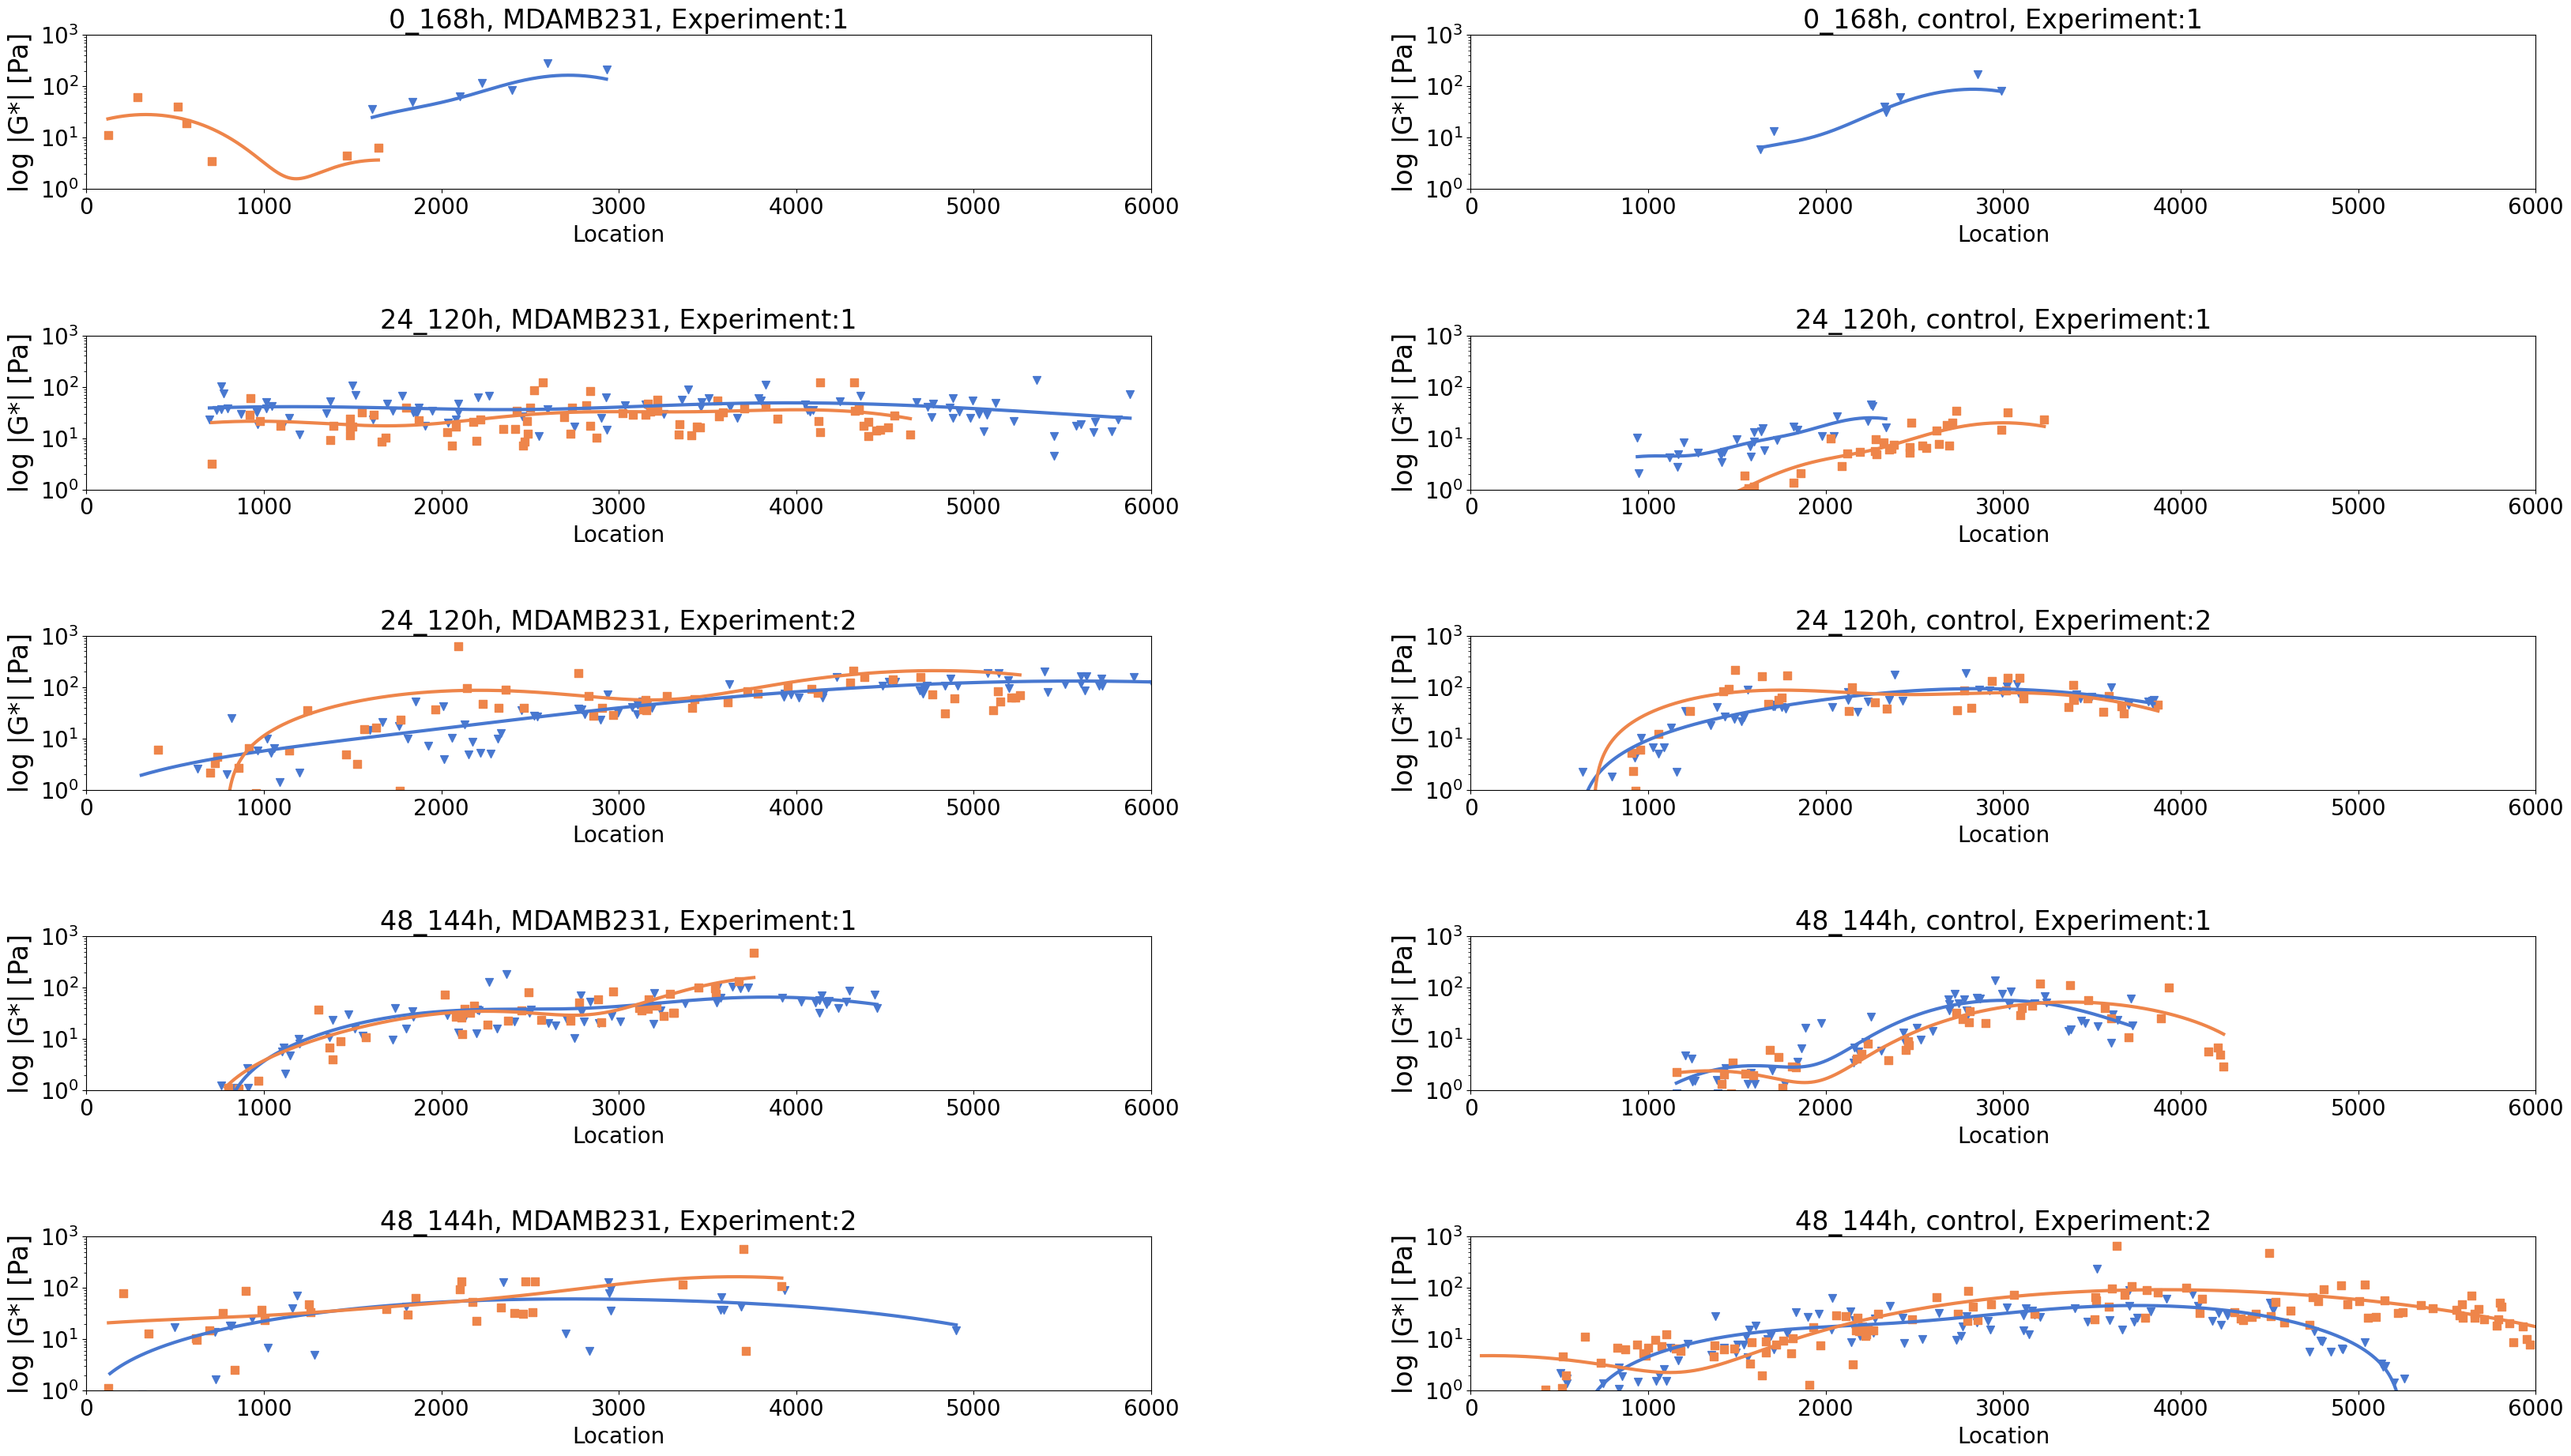

In [100]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['G_abs'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)
    ax.set_ylim(1, 1000)

    ax.set_yscale('log')
def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


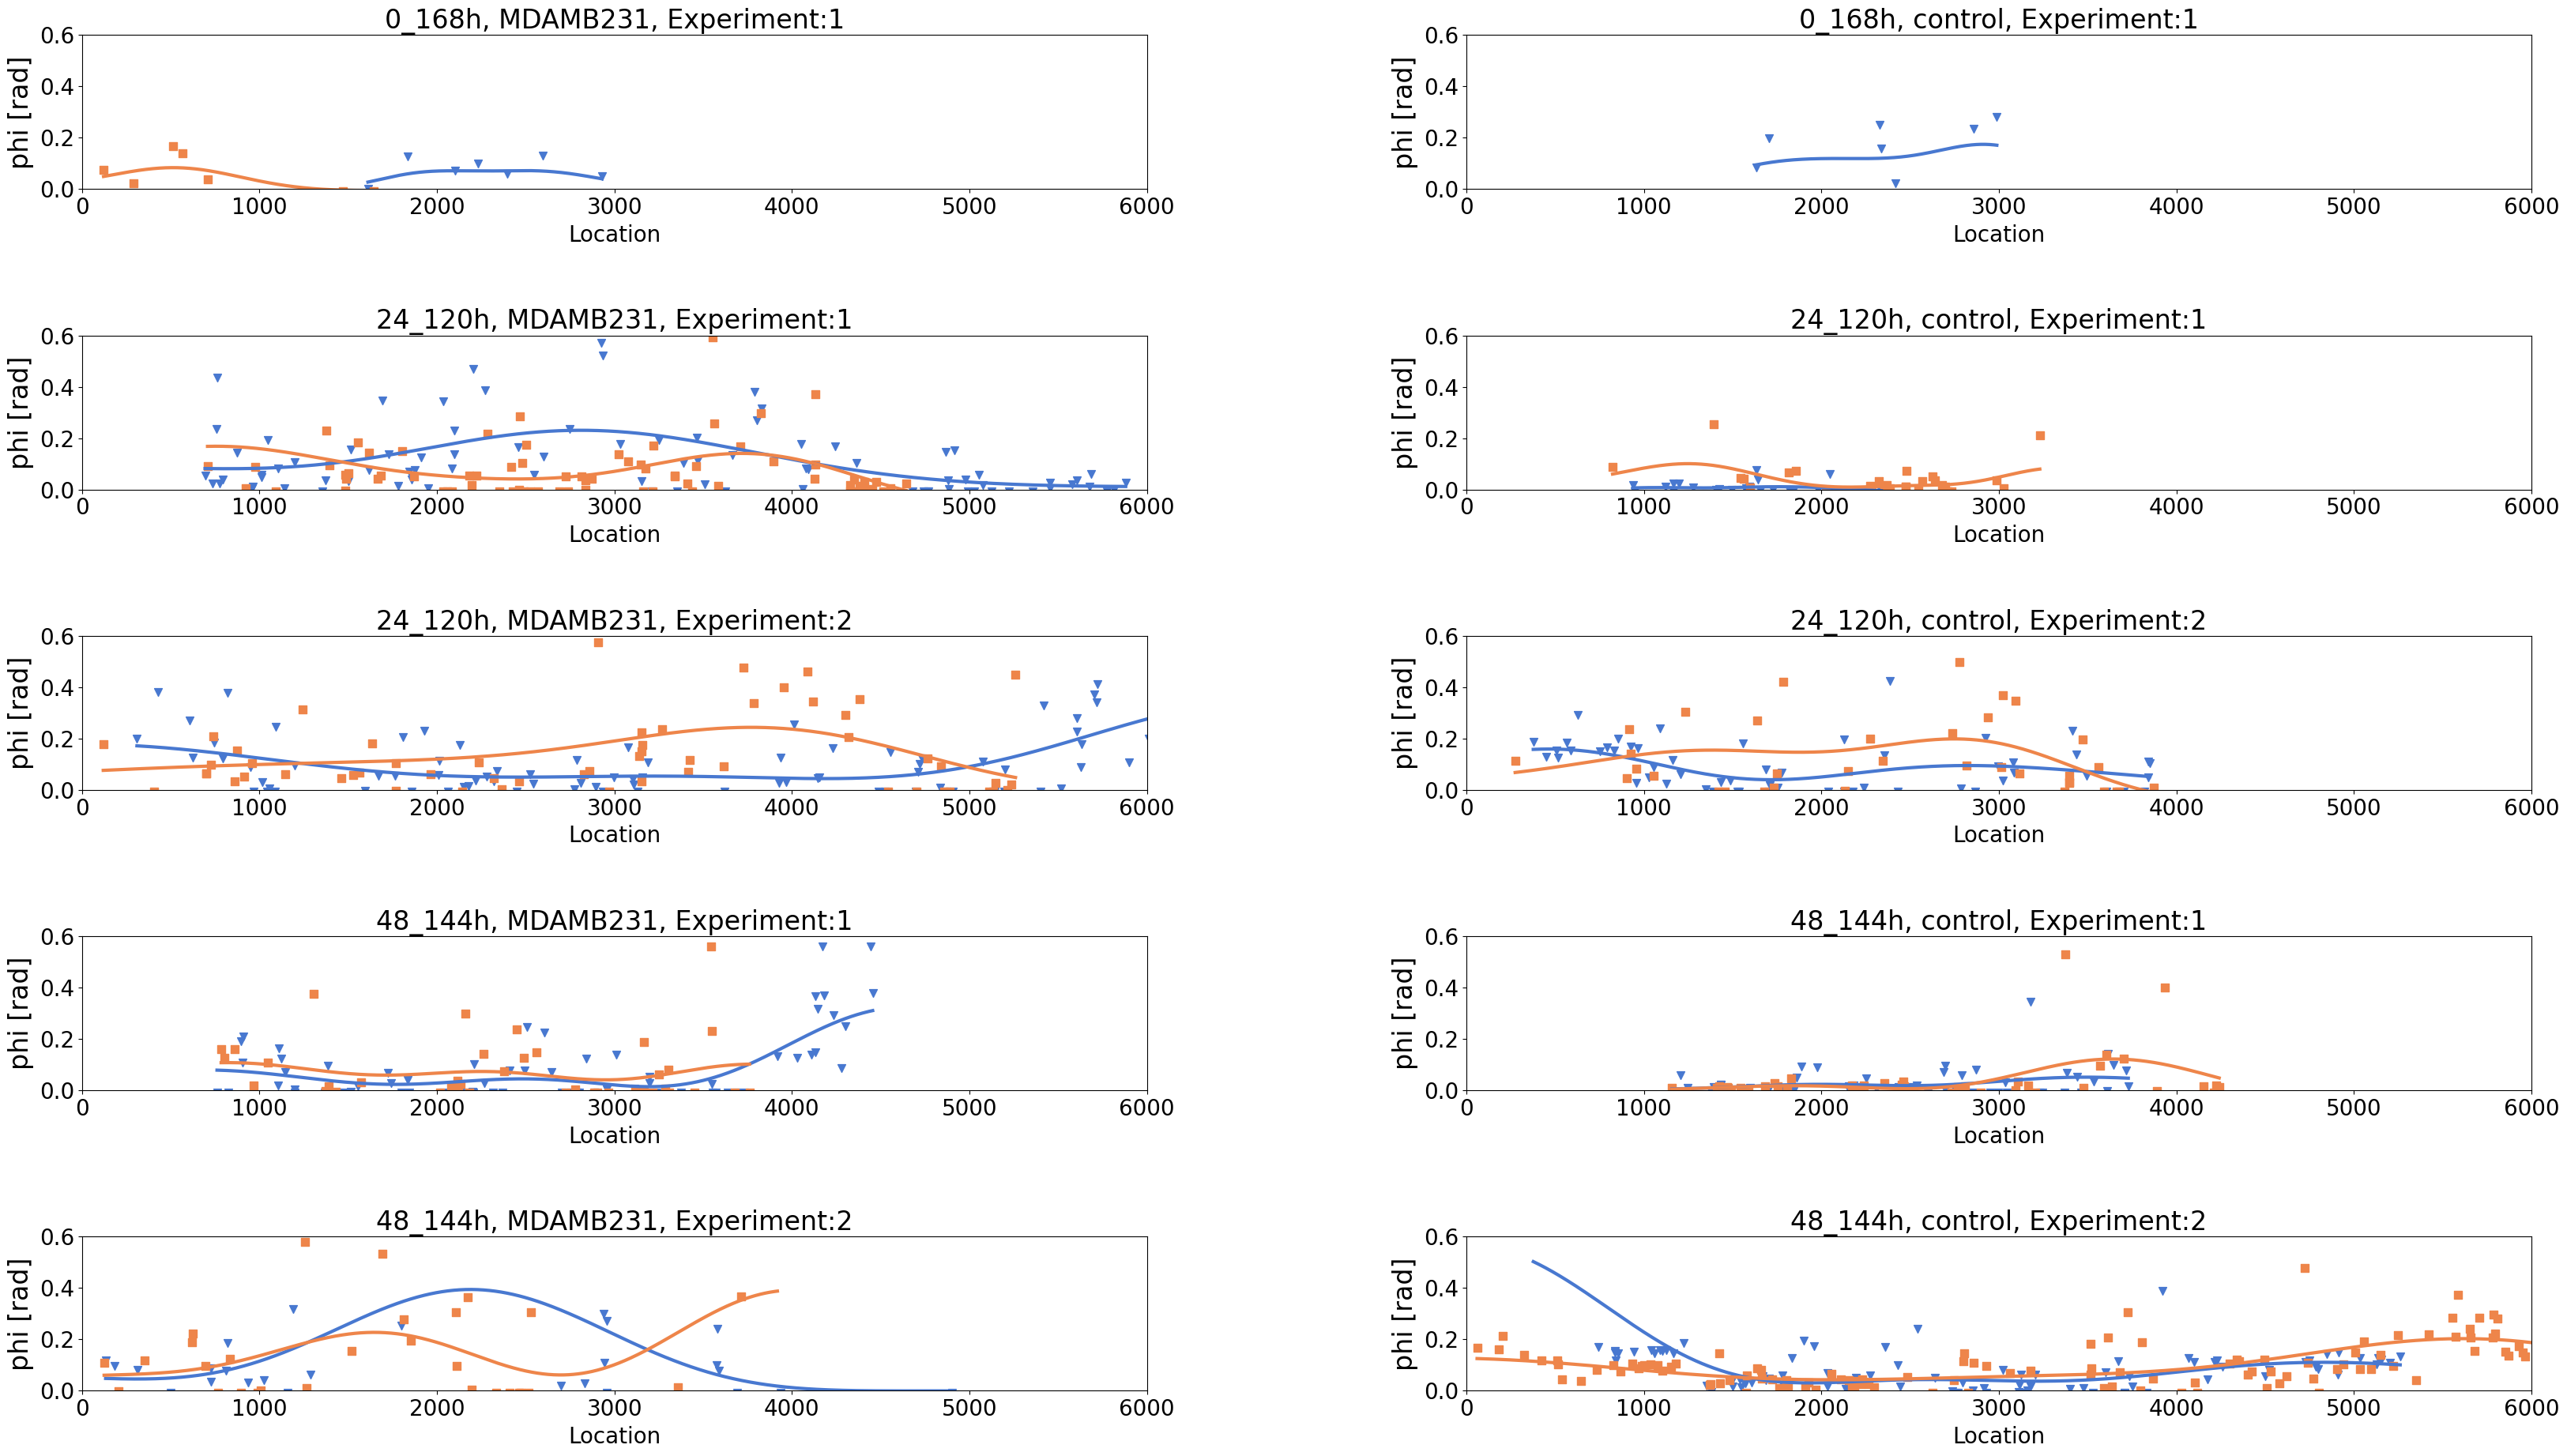

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['phi_(rad)'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


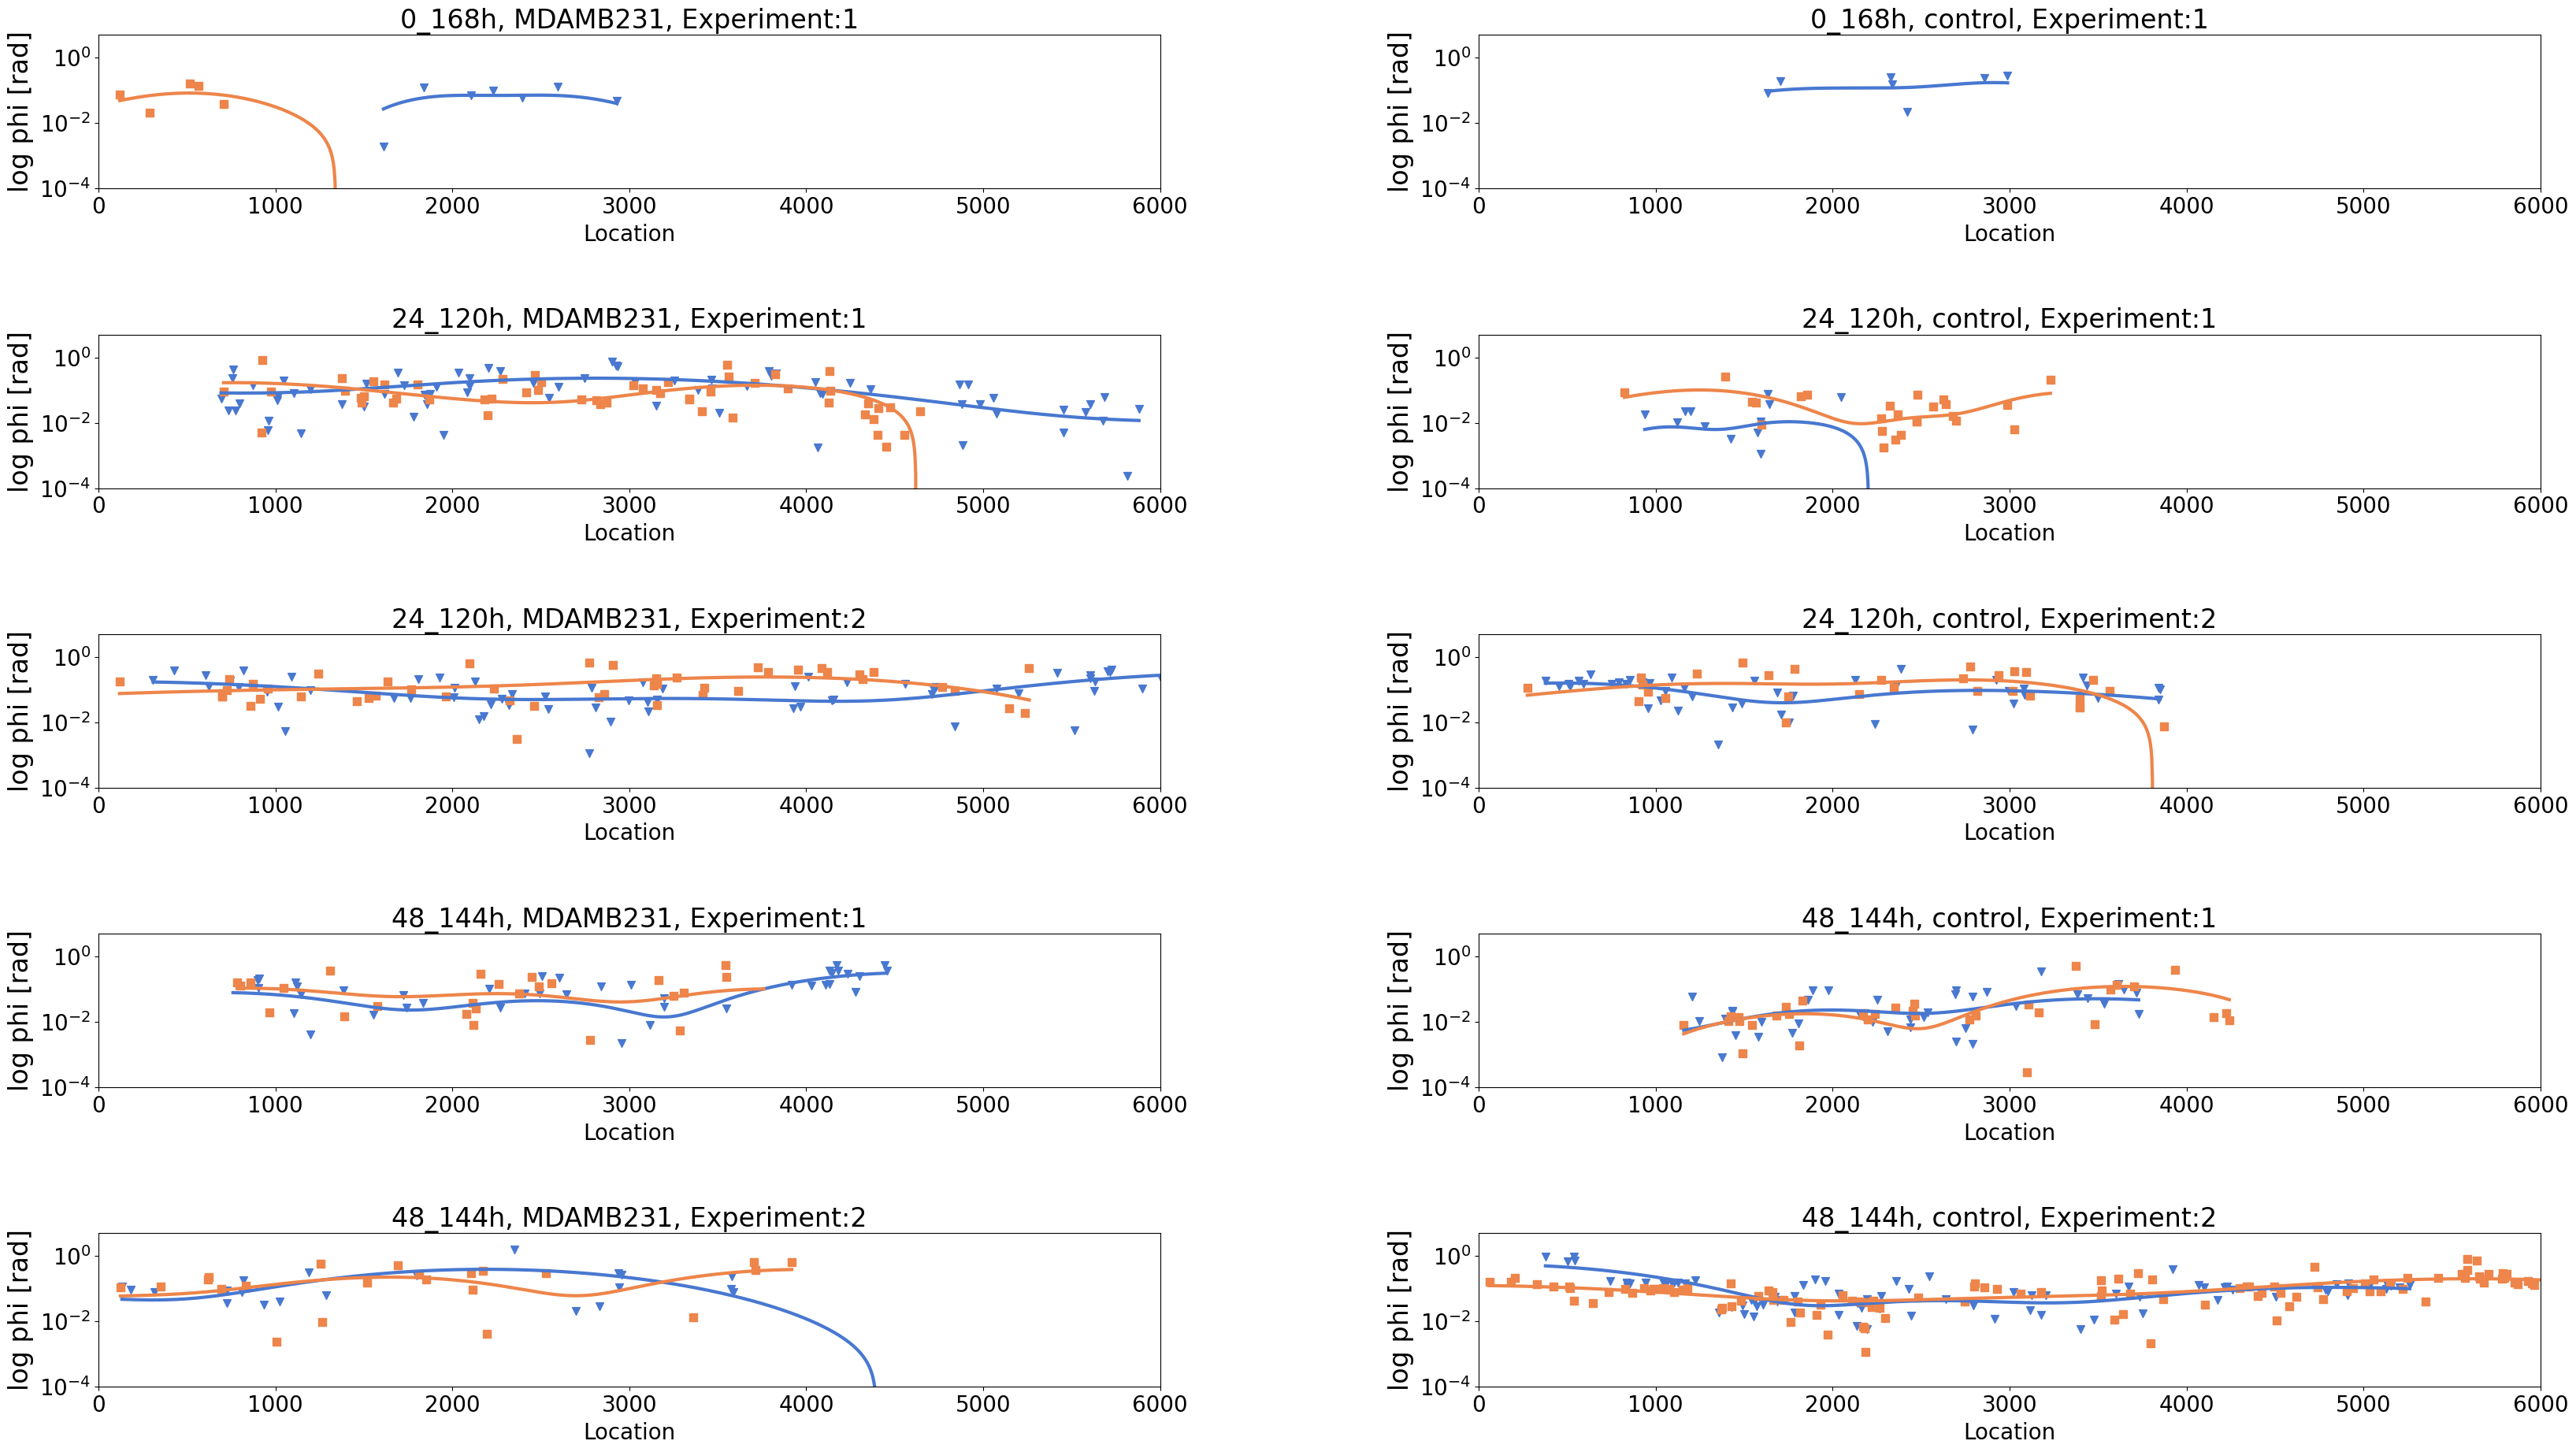

In [102]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

markers = ['v', 's']
colors = sns.color_palette("muted",2)

def plotting(group_data,j, ax, exp_type, incubation_set, experiment):
    if (group_data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = group_data['gradient_inverse']
    else:
        x_data = group_data['gradient']
    
    fitting_kernel(x_data, group_data['phi_(rad)'], ax, 1, colors[j], markers[j])

    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, {exp_type}, Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_yscale('log')
    ax.set_ylim(0.0001, 5)
    ax.set_xlim(0, 6000)

    ax.legend(title="Incubation [hours]", fontsize=20, title_fontsize=22, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
    ax.legend().set_visible(False)

def parse_incubation(group_data, ax, incubation_set, experiment, exp_type):
    group_data = group_data[group_data['cell/control'] == exp_type]
    
    for j, (incubation_value, group) in enumerate(group_data.groupby('incubation')):
        plotting(group, j, ax, exp_type, incubation_set, experiment)

for i, ((incubation_set, experiment), group_data) in enumerate(download.groupby(['incubation_set', 'experiment'])):
    parse_incubation(group_data, axs[i, 0], incubation_set, experiment, 'MDAMB231')
    parse_incubation(group_data, axs[i, 1], incubation_set, experiment, 'control')

plt.show()


Binned plot by locations

Time-series G*

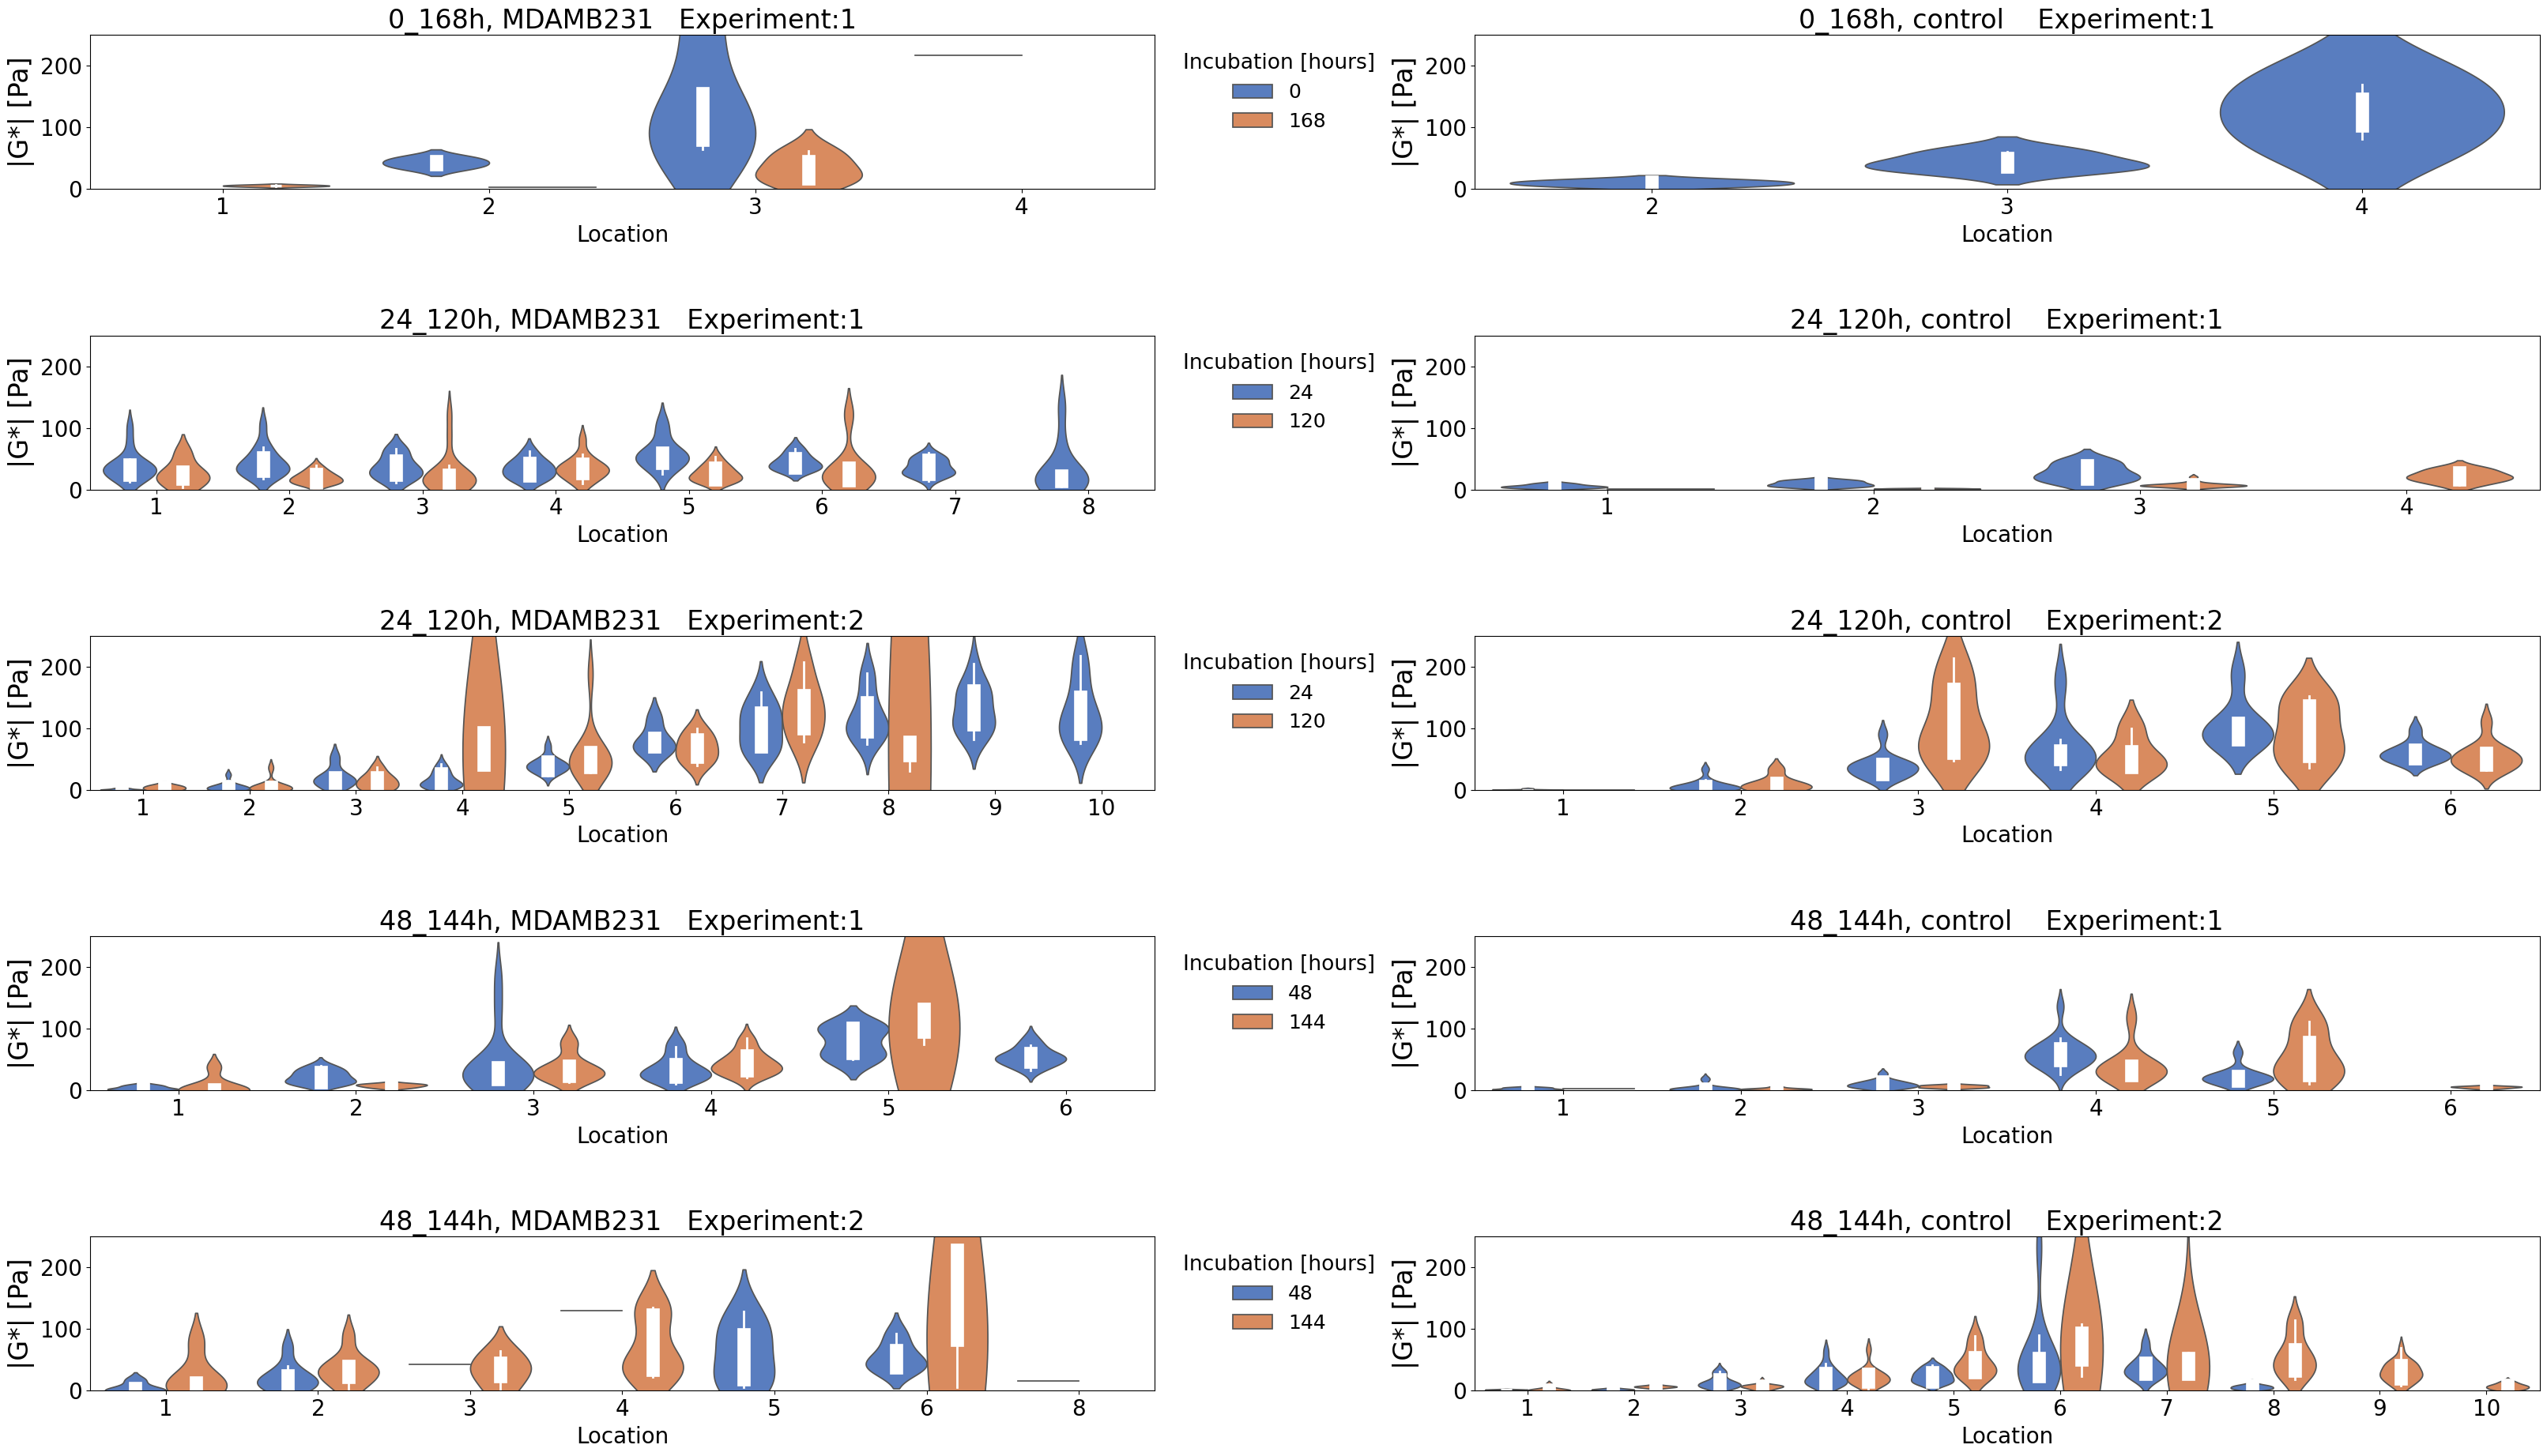

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ("muted",2)

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='G_abs', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 250) 


    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='G_abs', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*| [Pa]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 250) 



for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


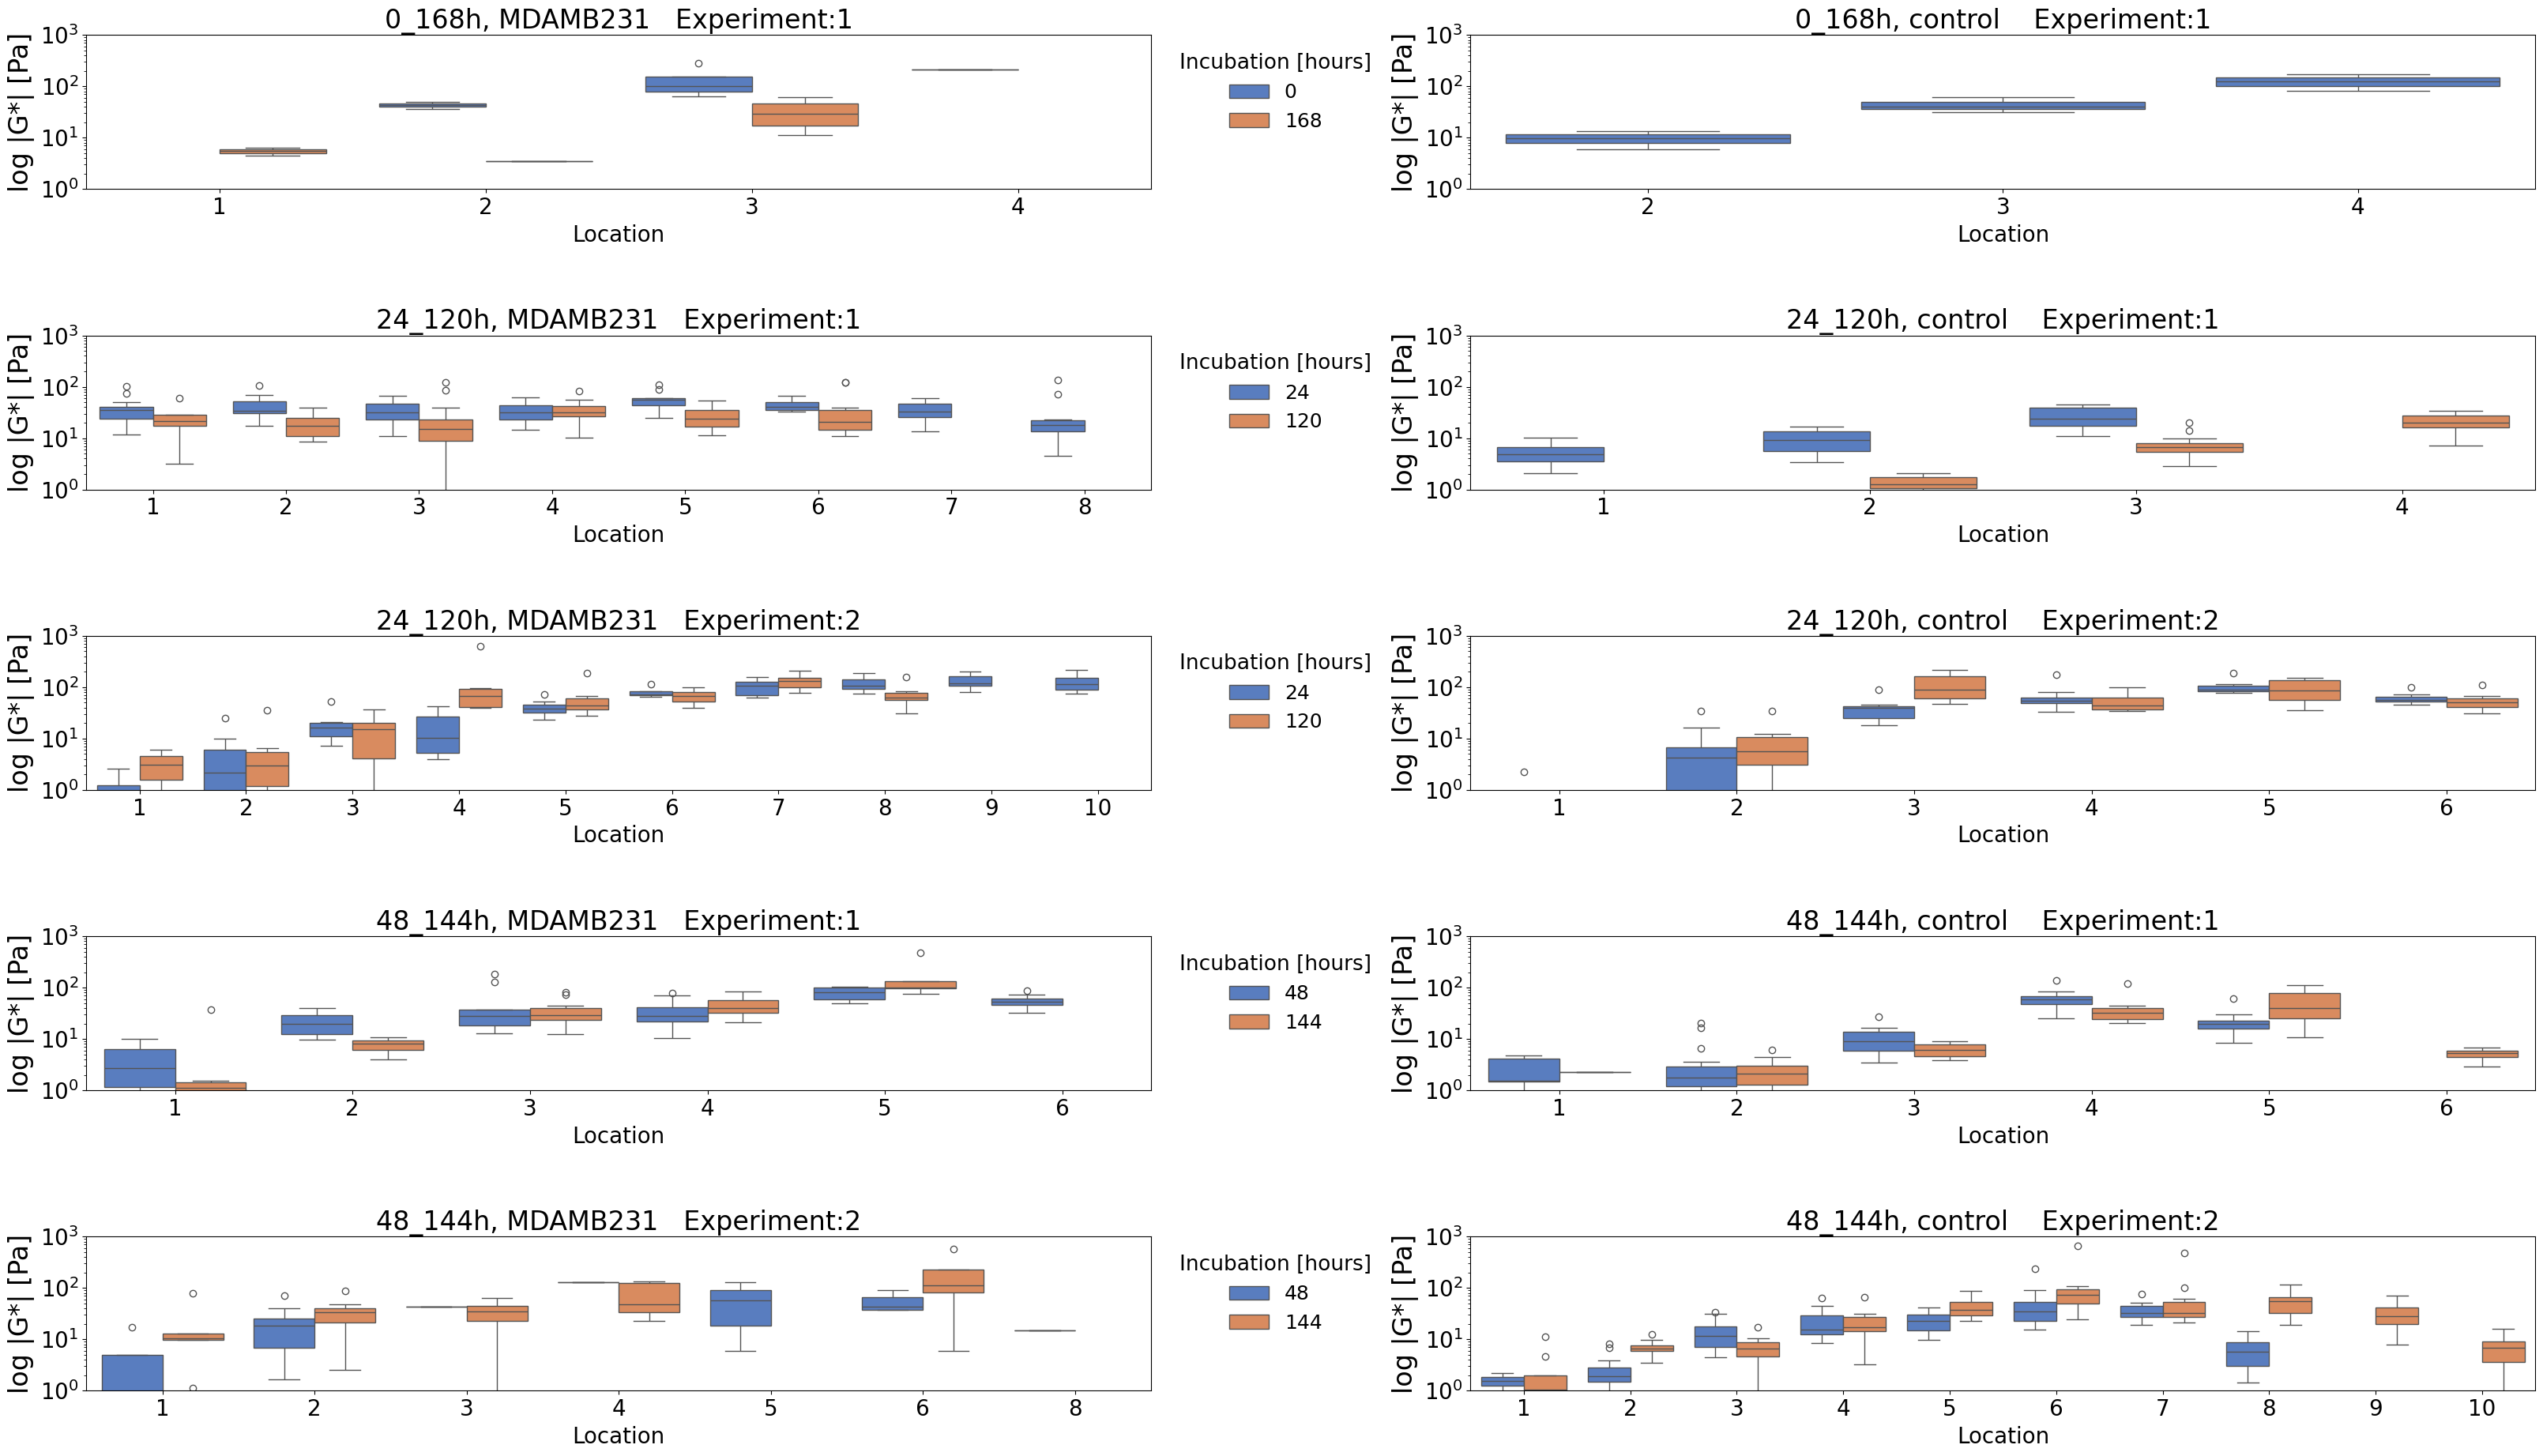

In [150]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ("muted",2)

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.boxplot(x=x_cell_data, y='G_abs', data=group_data_cell,
                    width=0.8, ax=ax, legend=True, hue='incubation',palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_yscale('log')
    ax.set_ylim(1, 1000) 


    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.boxplot(x=x_ctr_data, y='G_abs', data=group_data_control,
                  ax=ax1, legend=False, hue='incubation',
                   palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("log |G*| [Pa]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(1, 1000) 
    ax1.set_yscale('log')


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


Time-series G*

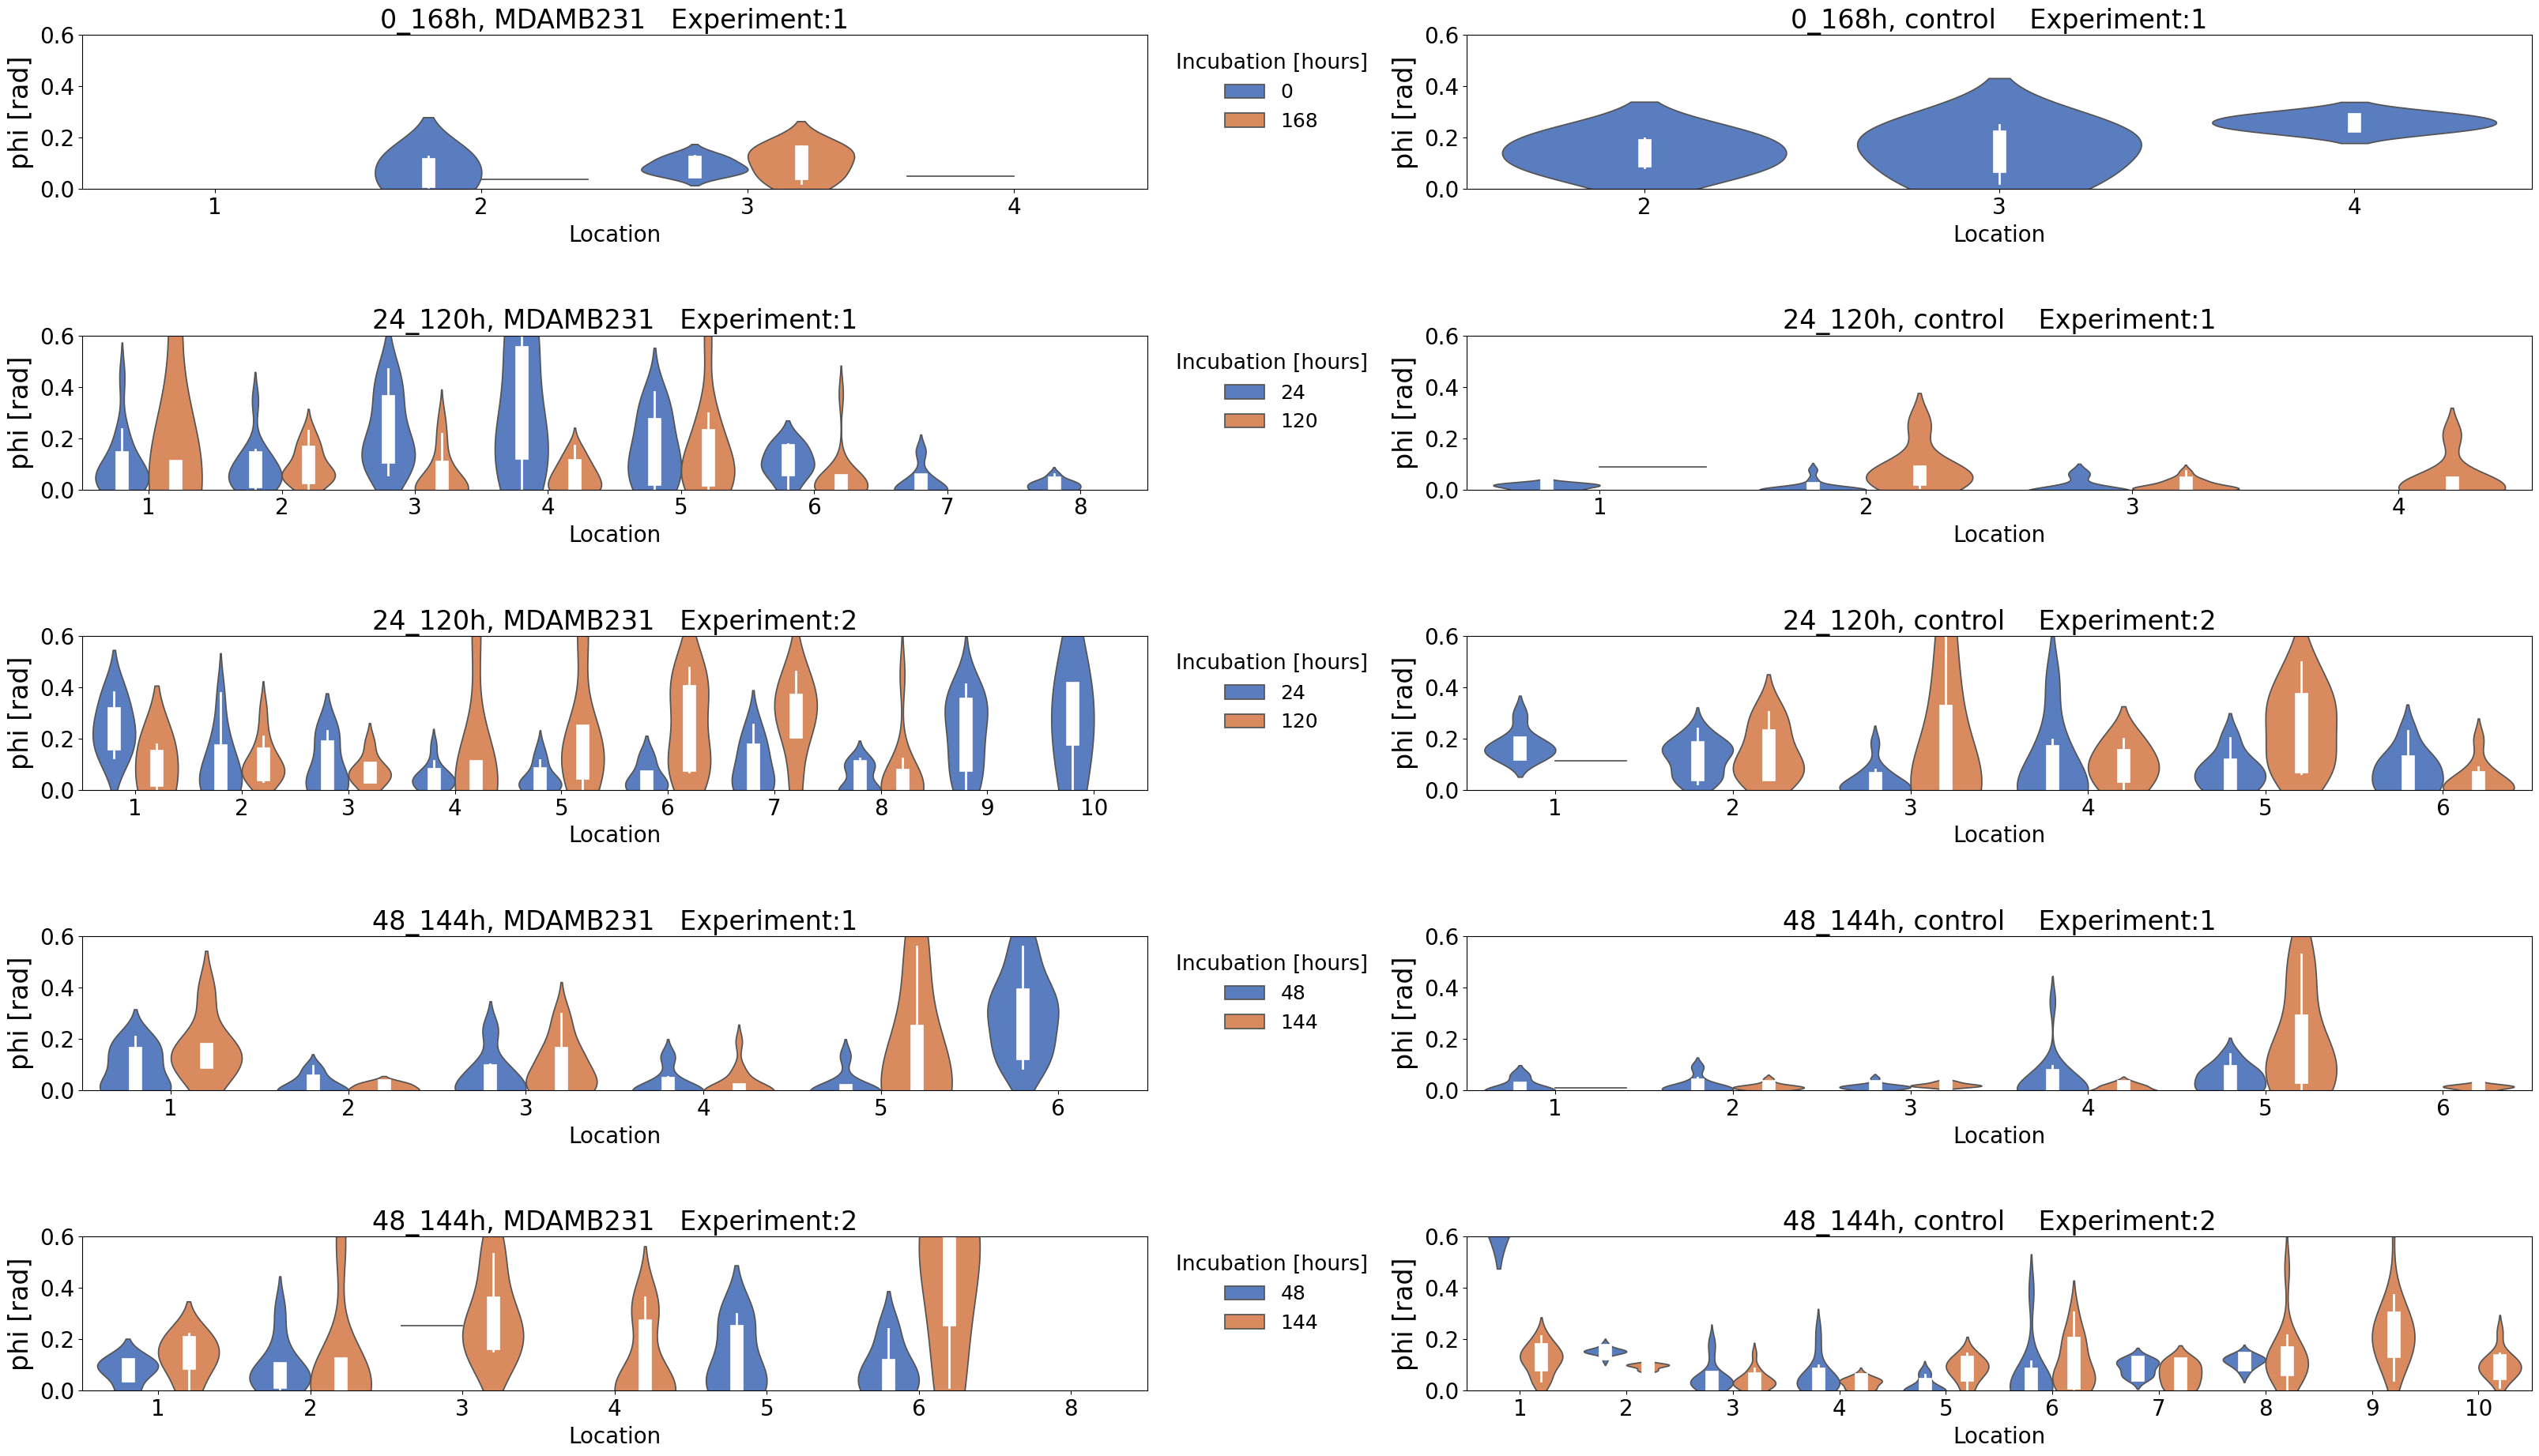

In [79]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.violinplot(x=x_cell_data, y='phi_(rad)', data=group_data_cell,
                    inner='box', width=0.8, density_norm='width', ax=ax, legend=True, hue='incubation',
                    inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0, 0.6) 
    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.violinplot(x=x_ctr_data, y='phi_(rad)', data=group_data_control,
                   inner='box', width=0.8, density_norm='width', ax=ax1, legend=False, hue='incubation',
                   inner_kws=dict(box_width=12, whis_width=2, color="1"),palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("phi [rad]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0, 0.6) 


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


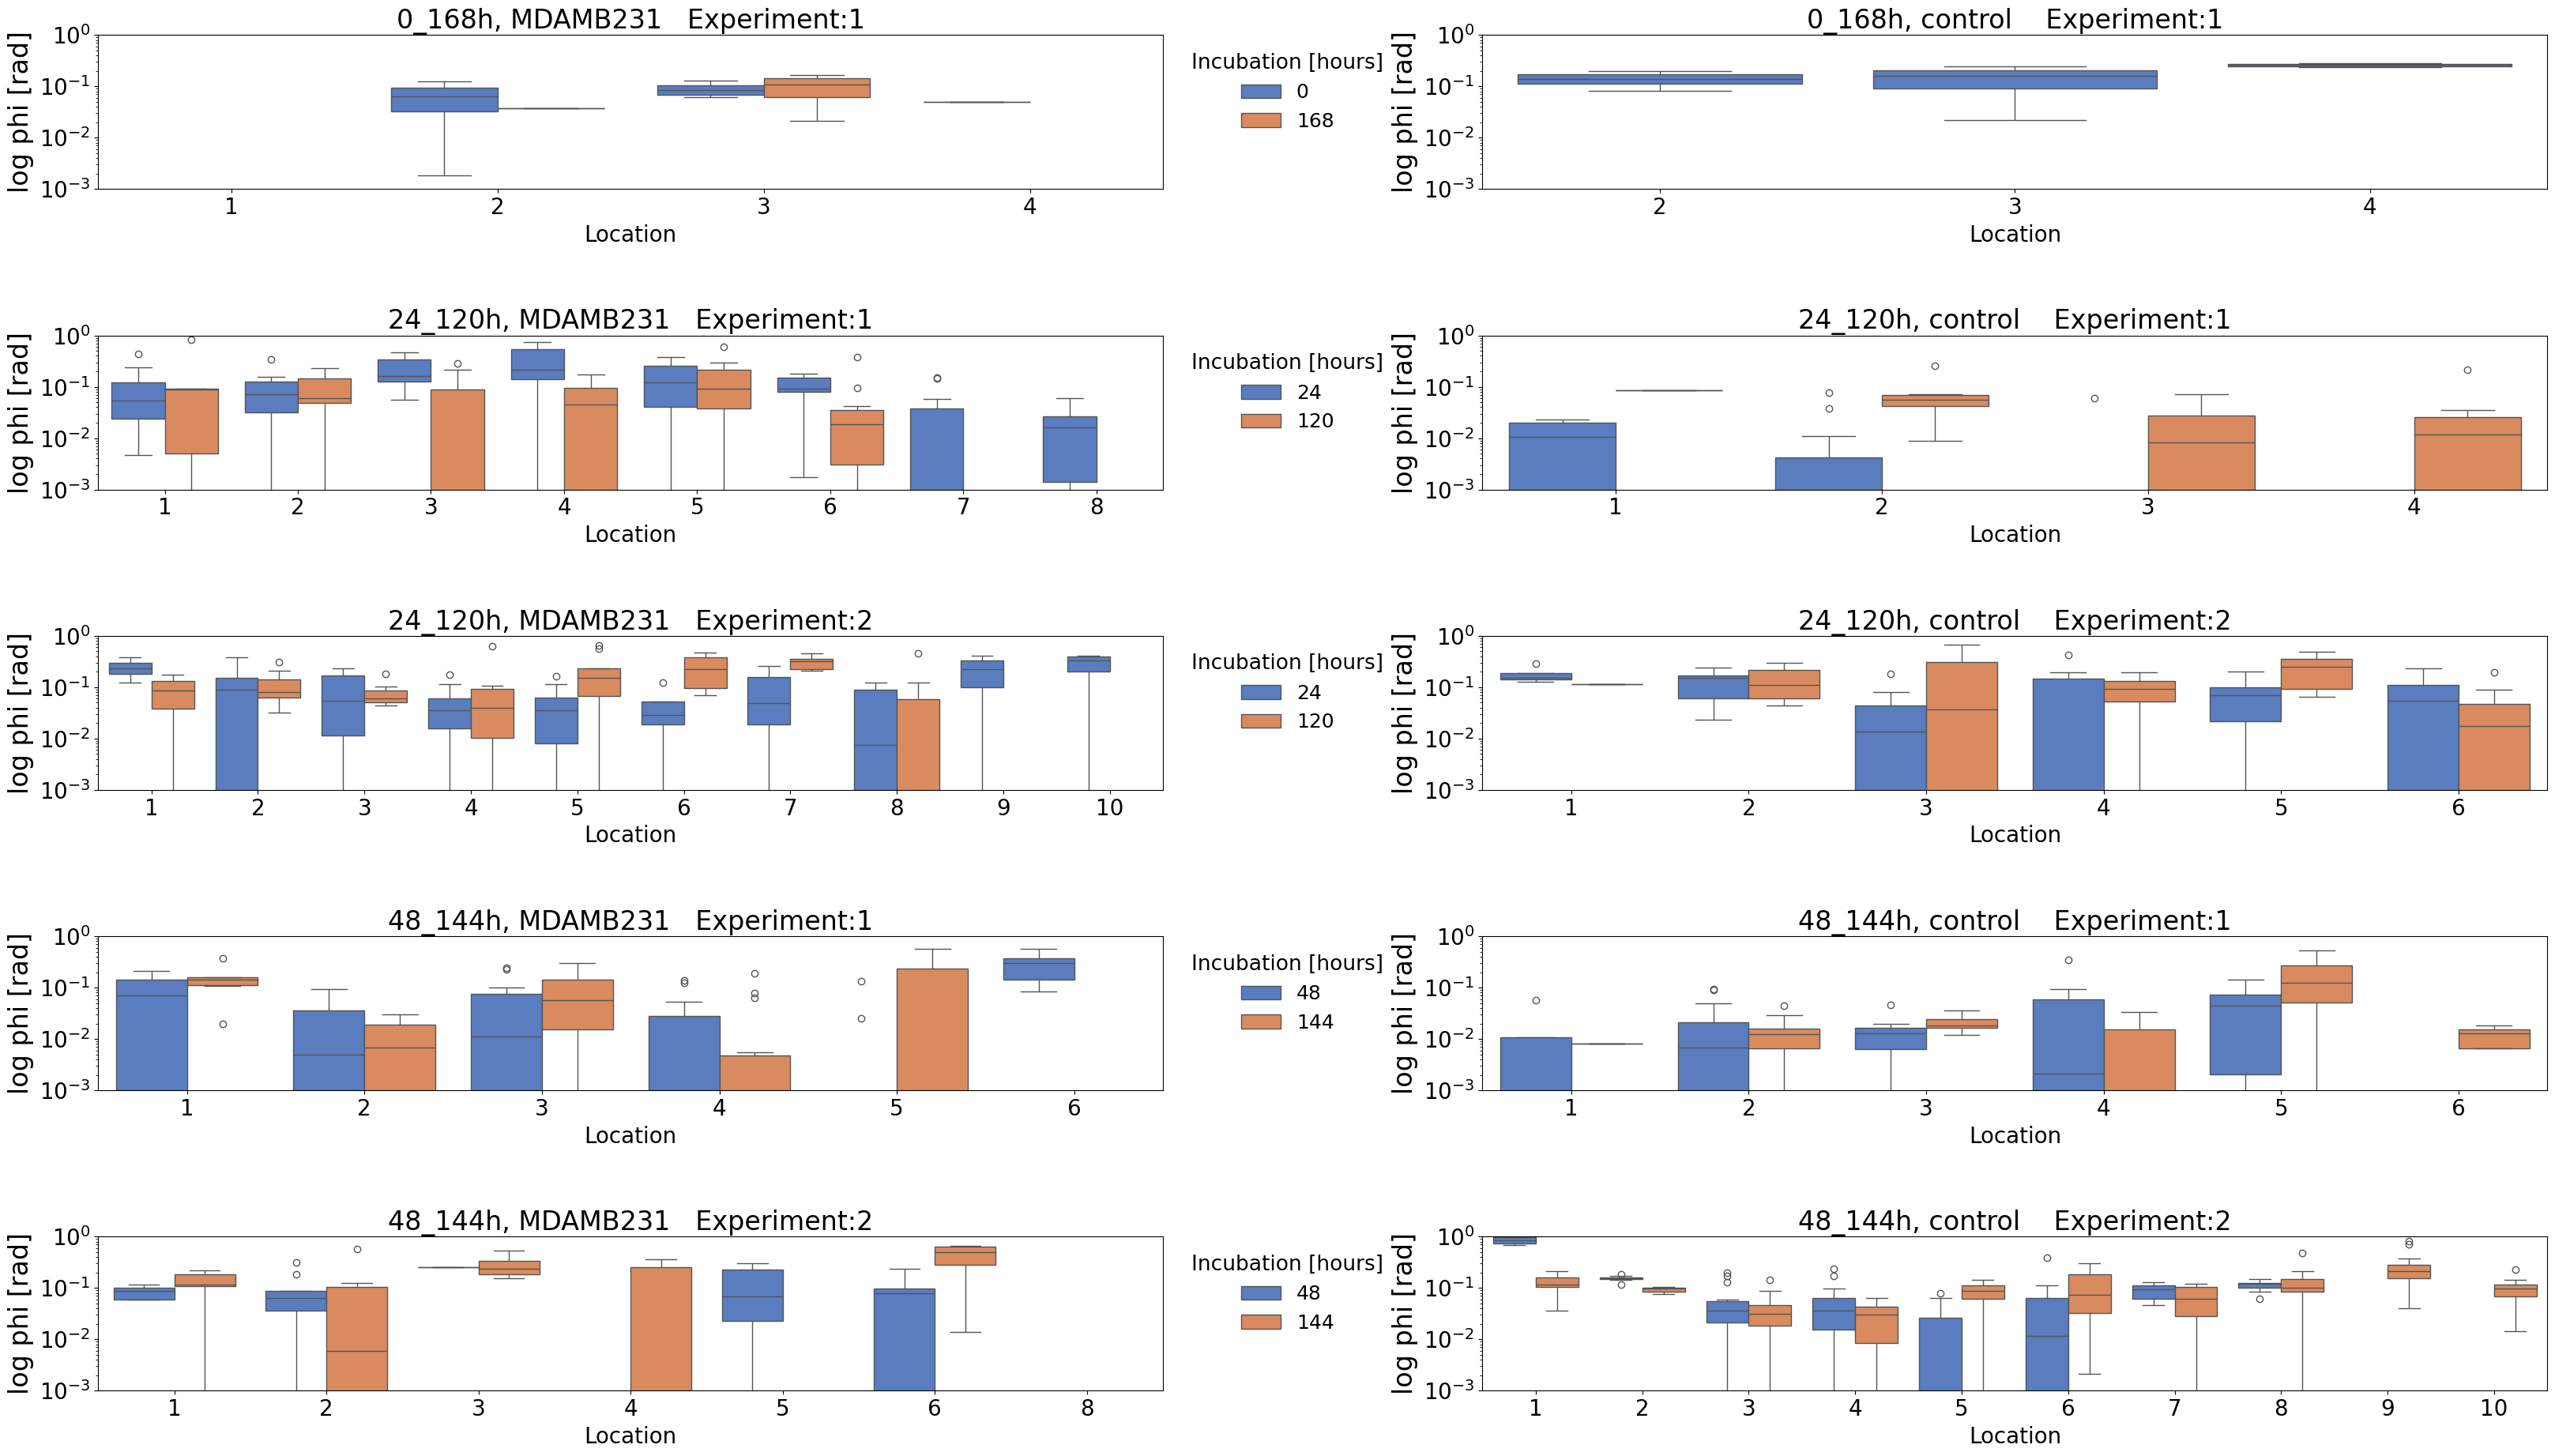

In [123]:
fig, axs = plt.subplots(5, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) # Adjust bottom to make space for the legend
# fig.suptitle("Remodelling UV=50s ", fontsize=22)

# Define marker and color settings (if needed)
markers = ['x', 's']
colors = ["lightblue", "darkblue"]

def plotting(group_data,i,experiment,incubation_set):
    
    ax = axs[i, 0]
    group_data_control, x_cell_data = [],[]
    group_data_cell = group_data[group_data['cell/control']=='MDAMB231']
    if (group_data_cell['gradient_direction'] == 'stiff_to_soft').all():x_cell_data = group_data_cell['location_inverse']
    else: x_cell_data = group_data_cell['location']
    
    sns.boxplot(x=x_cell_data, y='phi_(rad)', data=group_data_cell,
                    width=0.8, ax=ax, legend=True, hue='incubation',
                    palette="muted",)
    ax.set_xlabel("Location", fontsize=20, labelpad=5)
    ax.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax.set_title(f"{incubation_set}h, MDAMB231   Experiment:{experiment+1}", fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylim(0.001, 1)
    ax.set_yscale('log')
    legend = ax.legend(title="Incubation [hours]", fontsize=18, title_fontsize=19, loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)


    ax1 = axs[i, 1]
    group_data_control, x_ctr_data = [],[]
    group_data_control = group_data[group_data['cell/control']=='control']
    if (group_data_control['gradient_direction'] == 'stiff_to_soft').all():x_ctr_data = group_data_control['location_inverse']
    else: x_ctr_data = group_data_control['location']
    sns.boxplot(x=x_ctr_data, y='phi_(rad)', data=group_data_control,
                   width=0.8, ax=ax1, legend=False, hue='incubation',
                  palette="muted",)
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("log phi [rad]", fontsize=24, labelpad=5)
    ax1.set_title(f"{incubation_set}h, control    Experiment:{experiment+1}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0.001, 1)
    ax1.set_yscale('log')


for i, ((incubation_set,experiment), group_data) in enumerate(download.groupby(['incubation_set','experiment'])):
    plotting(group_data,i,experiment,incubation_set)


# Adjust layout and display the plot
plt.show()


Plotting CLOSBY

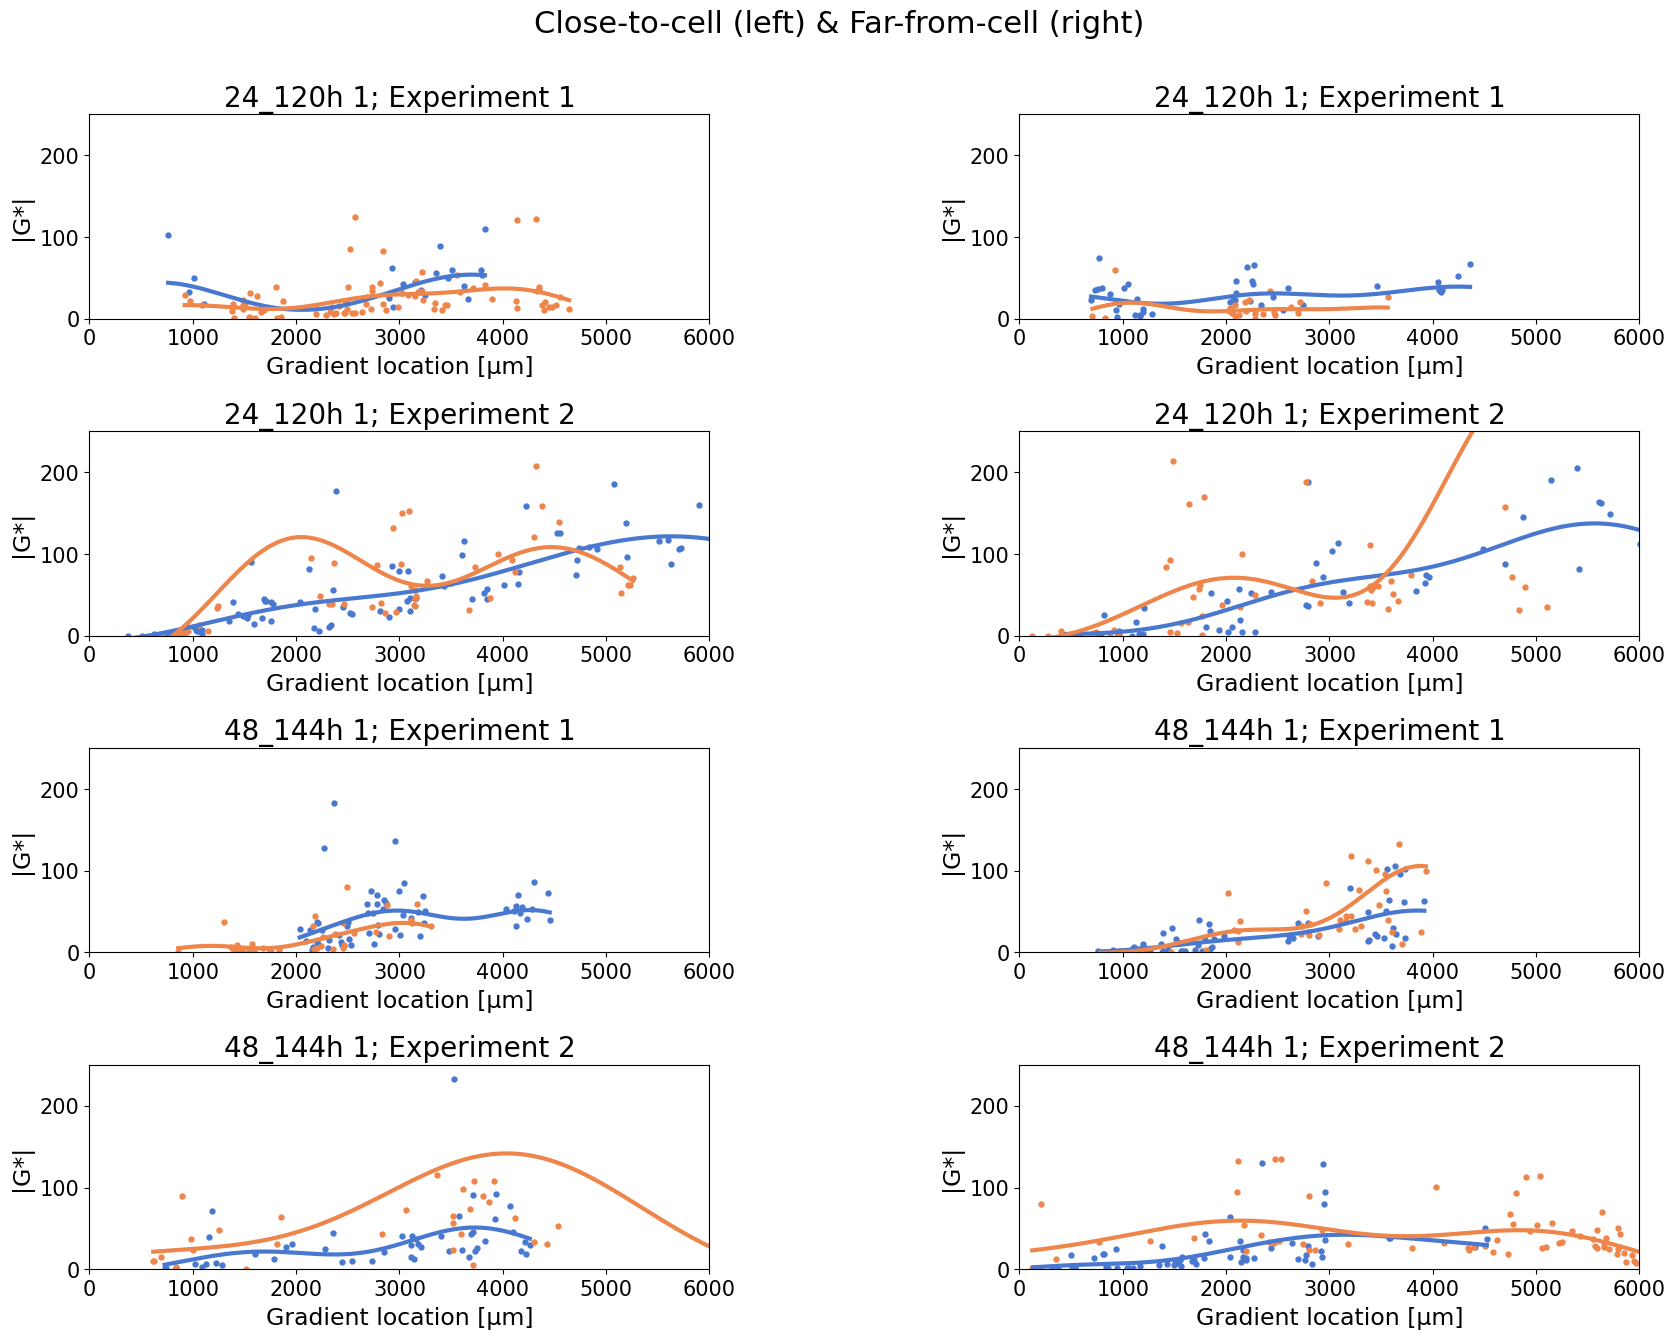

In [124]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15))  # 4 rows and 2 columns
plt.subplots_adjust(wspace=0.5, hspace=0.55)
fig.suptitle("Close-to-cell (left) & Far-from-cell (right)", fontsize=22, y=0.95)

markers = ['x', 's']
colors = sns.color_palette("muted",2)

def plot_data(data, col, start_index=0):
    for i, j in enumerate(data['incubation_set'].unique()):
        first = data[data['incubation_set'] == j]

        for nn, n in enumerate(first['incubation'].unique()):
            second = first[first['incubation'] == n]
            color_type = colors[int(nn)]

            for k, l in enumerate(second['experiment'].unique()):
                third = second[second['experiment'] == l]
                marker_type = markers[int(l)]

                for m, o in enumerate(third['sample'].unique()):
                    fourth = third[third['sample'] == o]
                    date_value = str(fourth['day'].unique()[0])
                    
                    # Calculate row and column for axs grid
                    row = start_index + (i * 2) + k  # Adjust row index for more subplots
                    col = col # Alternate between the two columns

                    ax = axs[row, col]
                    # Adjust for the gradient direction
                    if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                        fitting_kernel(fourth['gradient_inverse'], fourth['G_abs'], ax, 1, color_type, '.')
                    else:
                        fitting_kernel(fourth['gradient'], fourth['G_abs'], ax, 1, color_type, '.')

                    ax.set_xlabel("Gradient location [µm]", fontsize=17, labelpad=5)
                    ax.set_ylabel("|G*|", fontsize=17, labelpad=5)
                    ax.set_title(f"{j}h {o}; Experiment {k+1}", fontsize=20)
                    ax.tick_params(axis='both', labelsize=15)
                    ax.set_ylim(0, 250)
                    ax.set_xlim(0, 6000)

plot_data(download_closeby, 0)
plot_data(download_faraway, 1)


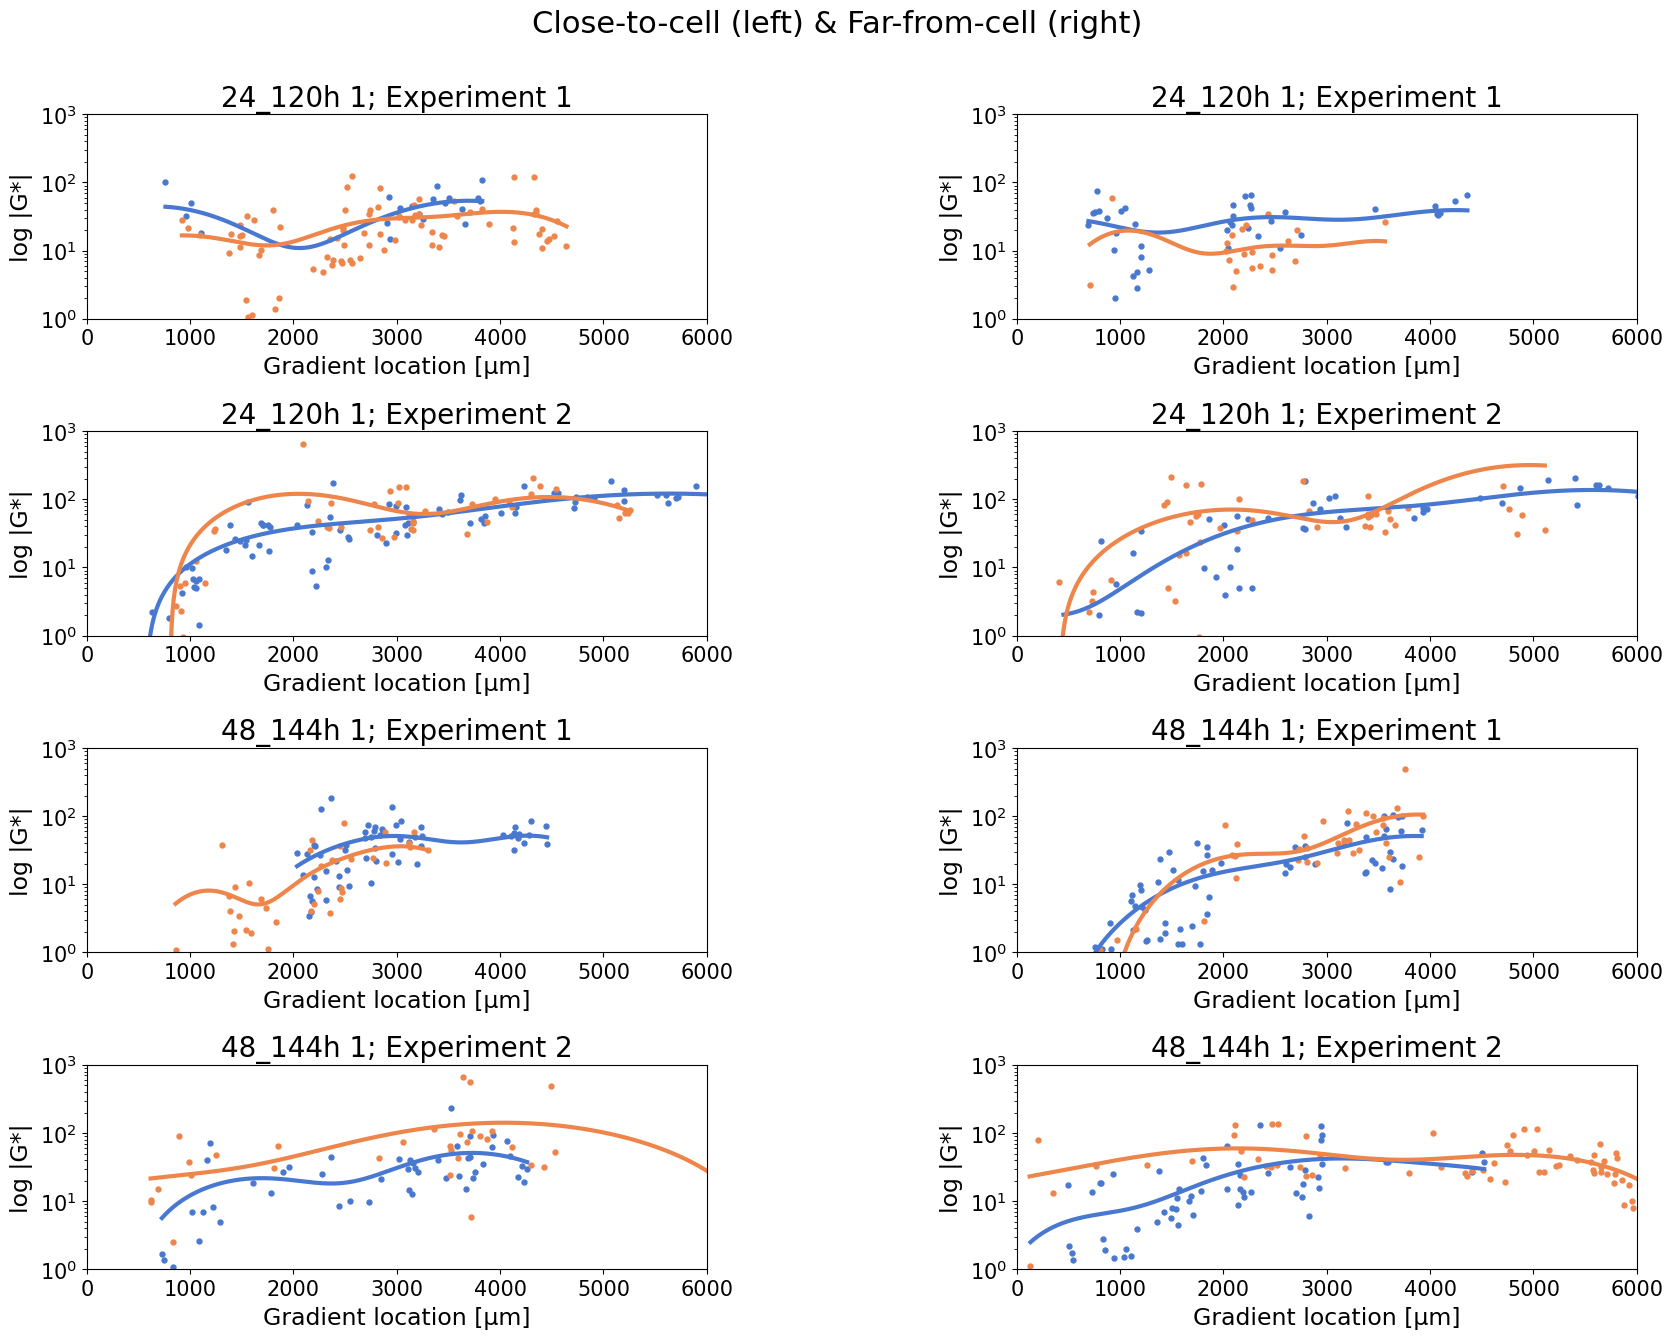

In [129]:
fig, axs = plt.subplots(4, 2, figsize=(20, 15))  # 4 rows and 2 columns
plt.subplots_adjust(wspace=0.5, hspace=0.55)
fig.suptitle("Close-to-cell (left) & Far-from-cell (right)", fontsize=22, y=0.95)

markers = ['x', 's']
colors = sns.color_palette("muted",2)

def plot_data(data, col, start_index=0):
    for i, j in enumerate(data['incubation_set'].unique()):
        first = data[data['incubation_set'] == j]

        for nn, n in enumerate(first['incubation'].unique()):
            second = first[first['incubation'] == n]
            color_type = colors[int(nn)]

            for k, l in enumerate(second['experiment'].unique()):
                third = second[second['experiment'] == l]
                marker_type = markers[int(l)]

                for m, o in enumerate(third['sample'].unique()):
                    fourth = third[third['sample'] == o]
                    date_value = str(fourth['day'].unique()[0])
                    
                    # Calculate row and column for axs grid
                    row = start_index + (i * 2) + k  # Adjust row index for more subplots
                    col = col # Alternate between the two columns

                    ax = axs[row, col]
                    # Adjust for the gradient direction
                    if (fourth['gradient_direction'] == 'stiff_to_soft').all():
                        fitting_kernel(fourth['gradient_inverse'], fourth['G_abs'], ax, 1, color_type, '.')
                    else:
                        fitting_kernel(fourth['gradient'], fourth['G_abs'], ax, 1, color_type, '.')

                    ax.set_xlabel("Gradient location [µm]", fontsize=17, labelpad=5)
                    ax.set_ylabel("log |G*|", fontsize=17, labelpad=5)
                    ax.set_title(f"{j}h {o}; Experiment {k+1}", fontsize=20)
                    ax.tick_params(axis='both', labelsize=15)
                    ax.set_yscale('log')
                    ax.set_ylim(1, 1000)
                    ax.set_xlim(0, 6000)

plot_data(download_closeby, 0)
plot_data(download_faraway, 1)


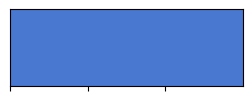

In [81]:
colors = sns.color_palette("muted", 3)[0]
sns.palplot(colors)
plt.show()


Setting the colors for each incubation time

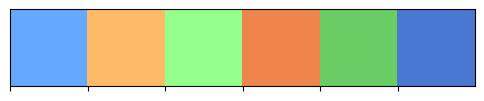

In [ ]:
import matplotlib.colors as mcolors

def darken_color(color, factor=0.6):
    rgb = np.array(mcolors.to_rgb(color)) 
    darkened_rgb = rgb * factor
    darkened_rgb = np.clip(darkened_rgb, 0, 1) 
    return mcolors.to_hex(darkened_rgb)  

colors = sns.color_palette("muted", 3)
color_1 = colors[0] 
color_2 = colors[1]  
color_3 = colors[2]  

light_color_1 = darken_color(color_1, factor=1.4)
light_color_2 = darken_color(color_2, factor=1.4)
light_color_3 = darken_color(color_3, factor=1.4)

final_palette = [light_color_1,light_color_2,light_color_3,color_2,color_3,color_1]
sns.palplot(final_palette)
plt.show()


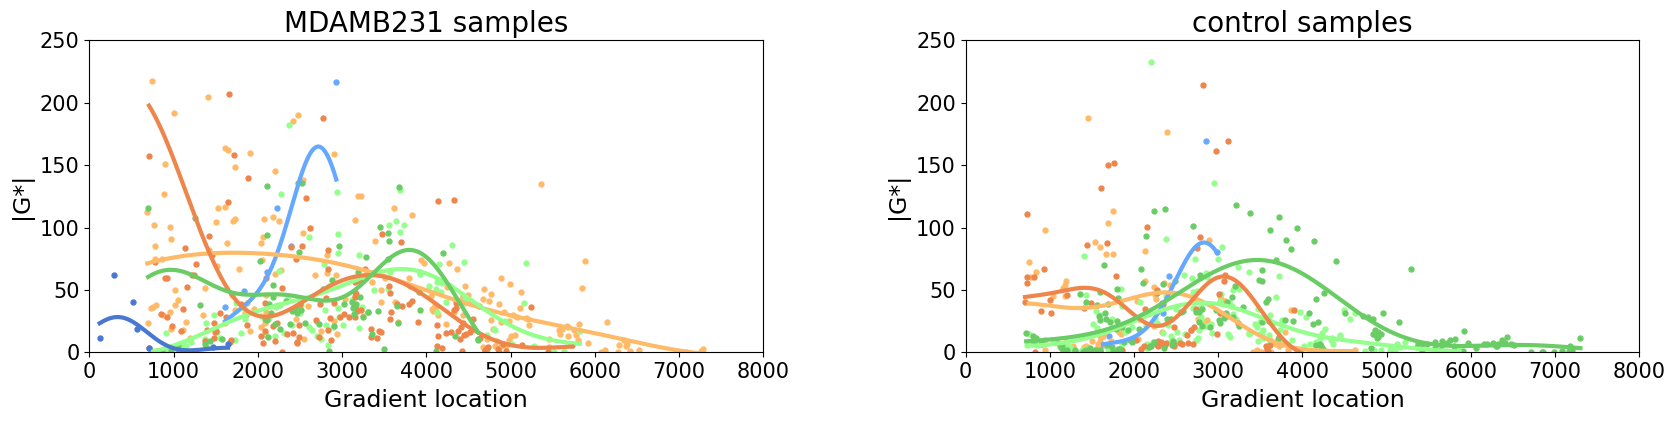

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['G_abs'], ax1, 1, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 250)
    ax1.set_xlim(0, 8000)


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


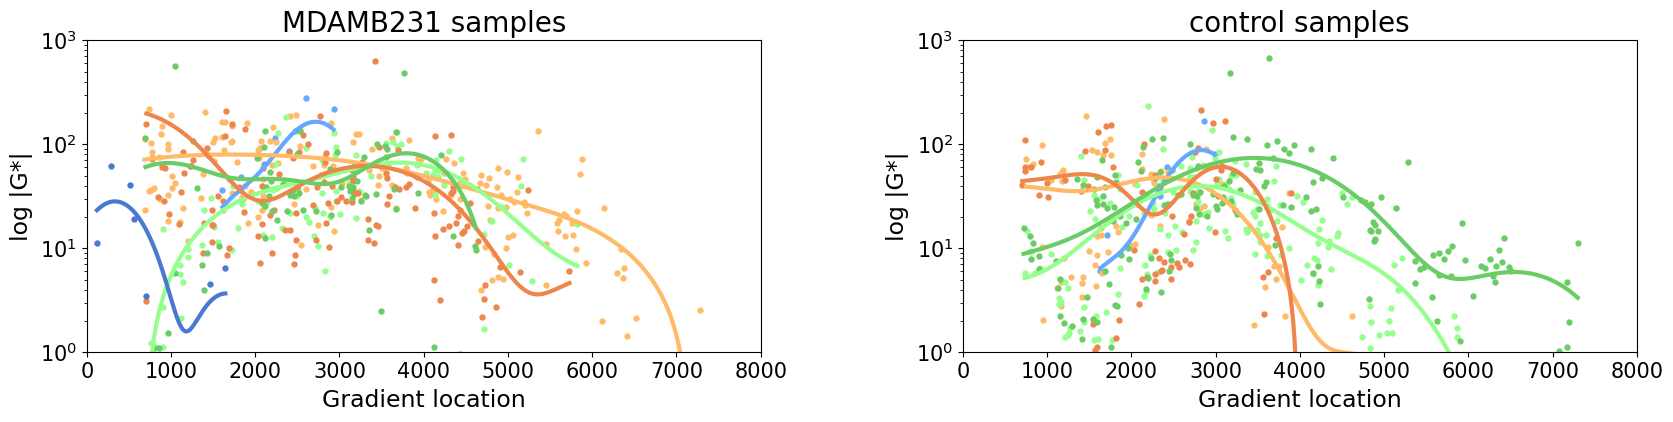

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['G_abs'], ax1, 1, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("log |G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    
    ax1.set_ylim(1, 1000)
    ax1.set_xlim(0, 8000)
    ax1.set_yscale('log')


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


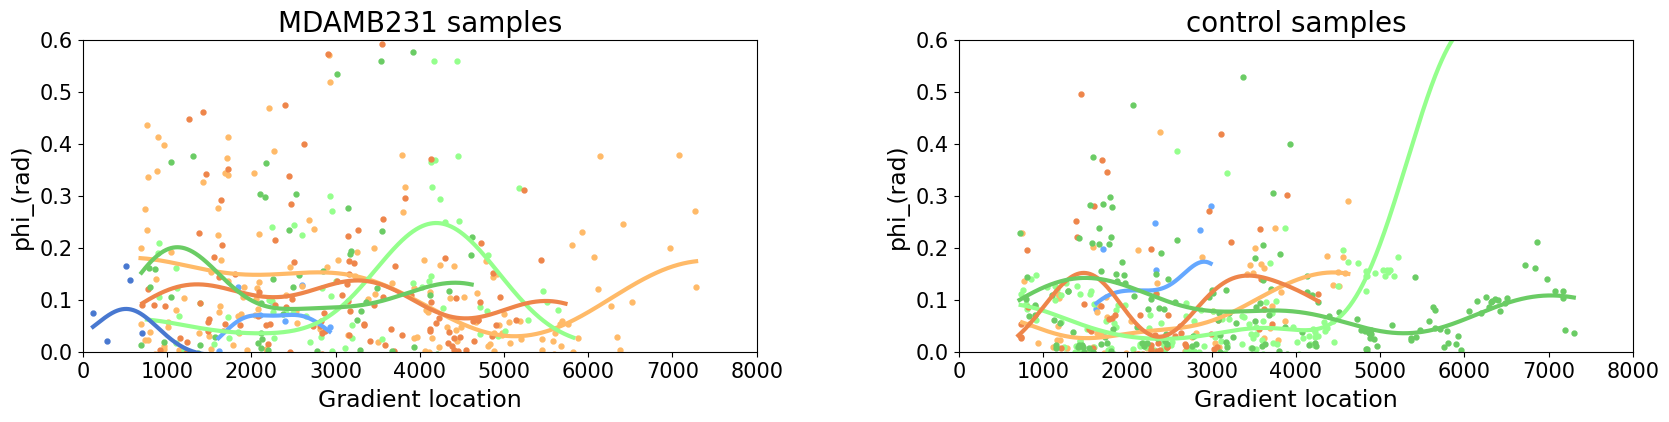

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
    # Default case or handle unexpected 'cell_ctr' values
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['phi_(rad)'], ax1, 1, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("phi_(rad)", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 0.6)
    ax1.set_xlim(0, 8000)


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


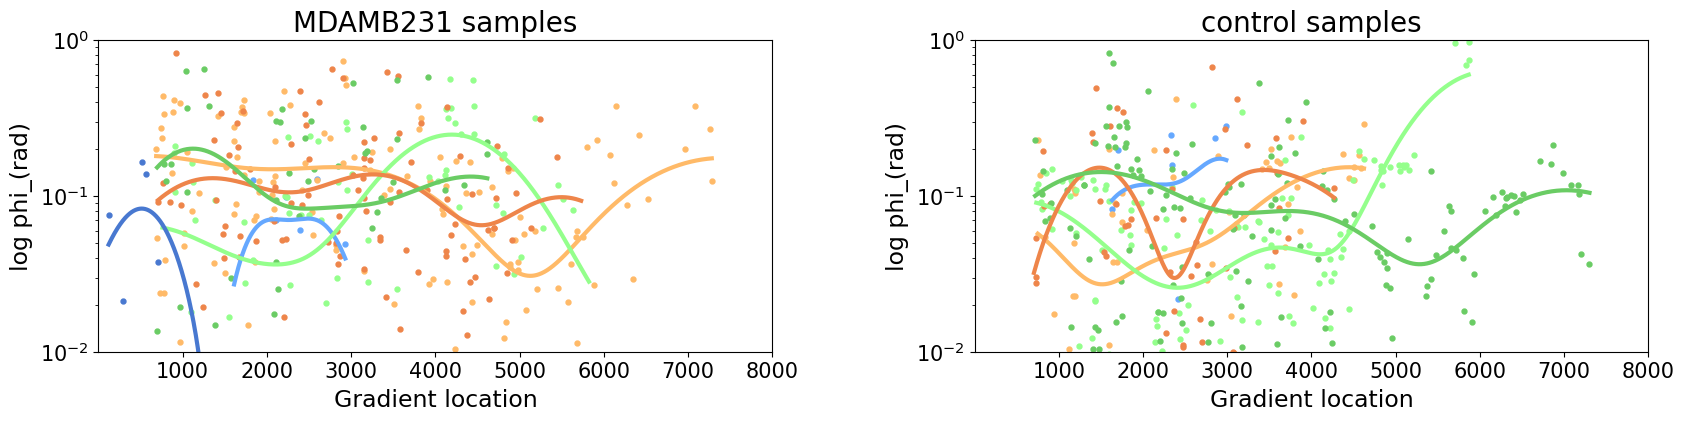

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1)  # Adjust bottom for the legend

colors = final_palette  # Adjust the number to the required number of colors

def plotting(grpp, color, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
    # Default case or handle unexpected 'cell_ctr' values
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")
        col = 0  # Default to column 0 (you can change this if necessary)

    
    ax1 = axs[col]

    if (grpp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grpp['gradient_inverse']
    else:
        x_data = grpp['gradient']
    
    fitting_kernel(x_data, grpp['phi_(rad)'], ax1, 1, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("log phi_(rad)", fontsize=17, labelpad=5)
    ax1.set_title(f"{cell_ctr[0]} samples", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0.01, 1)
    ax1.set_xlim(1, 8000)
    ax1.set_yscale('log')


def filtering(grp, i, incubation):  
    color = colors[i]  # Choose color based on index
    
    # Loop through each cell/control type and plot
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting(grpp, color, cell_ctr)

# Main loop over incubation groups
for i, (incubation, grp) in enumerate(download.groupby(['incubation'])):
    filtering(grp, i, incubation)  # Calling incubation function to handle plotting per group

# Adjust layout and display the plot
plt.show()


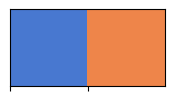

In [ ]:
import matplotlib.colors as mcolors

def darken_color(color, factor=0.6):
    rgb = np.array(mcolors.to_rgb(color))
    darkened_rgb = rgb * factor
    darkened_rgb = np.clip(darkened_rgb, 0, 1)
    return mcolors.to_hex(darkened_rgb)  

colors = sns.color_palette("muted", 3)
color_1 = colors[0]  
color_2 = colors[1]  

light_color_1 = darken_color(color_1, factor=1.4)
light_color_2 = darken_color(color_2, factor=1.4)

final_palette1 = [color_1,color_2]

sns.palplot(final_palette1)

plt.show()


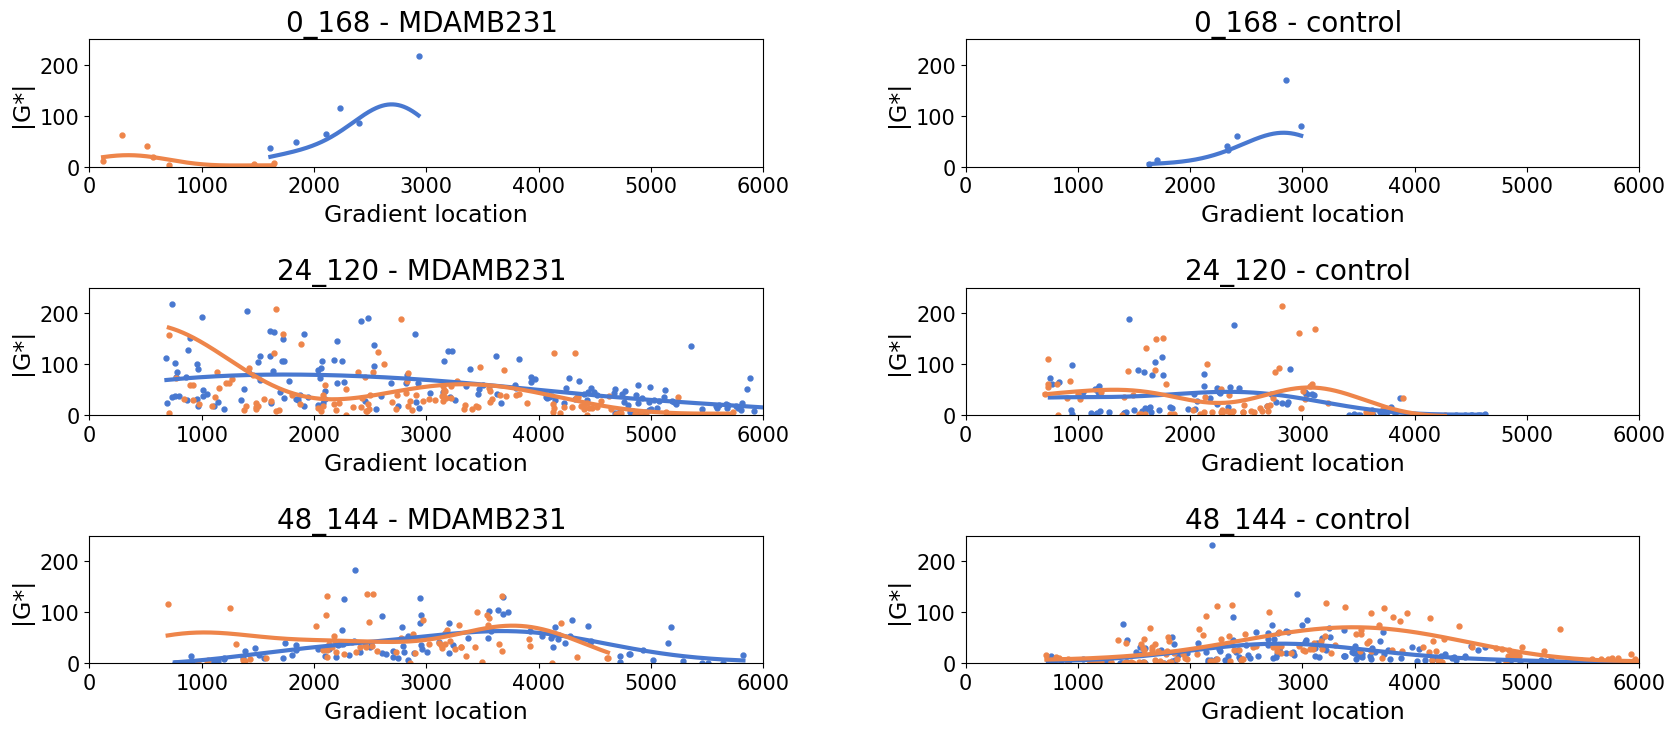

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['G_abs'], ax1, 2, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 250)
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


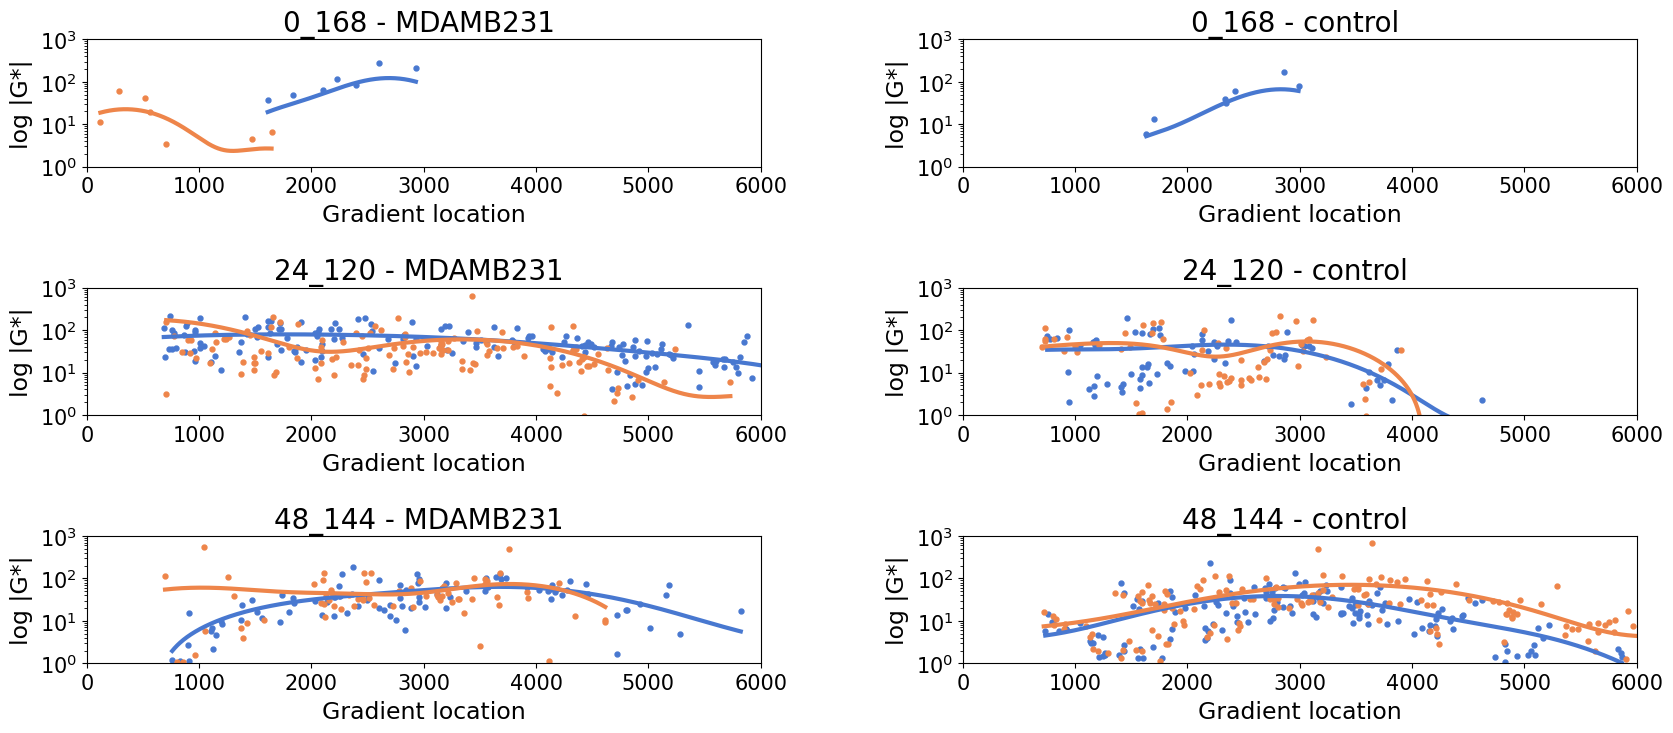

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['G_abs'], ax1, 2, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("log |G*|", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(1, 1000)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


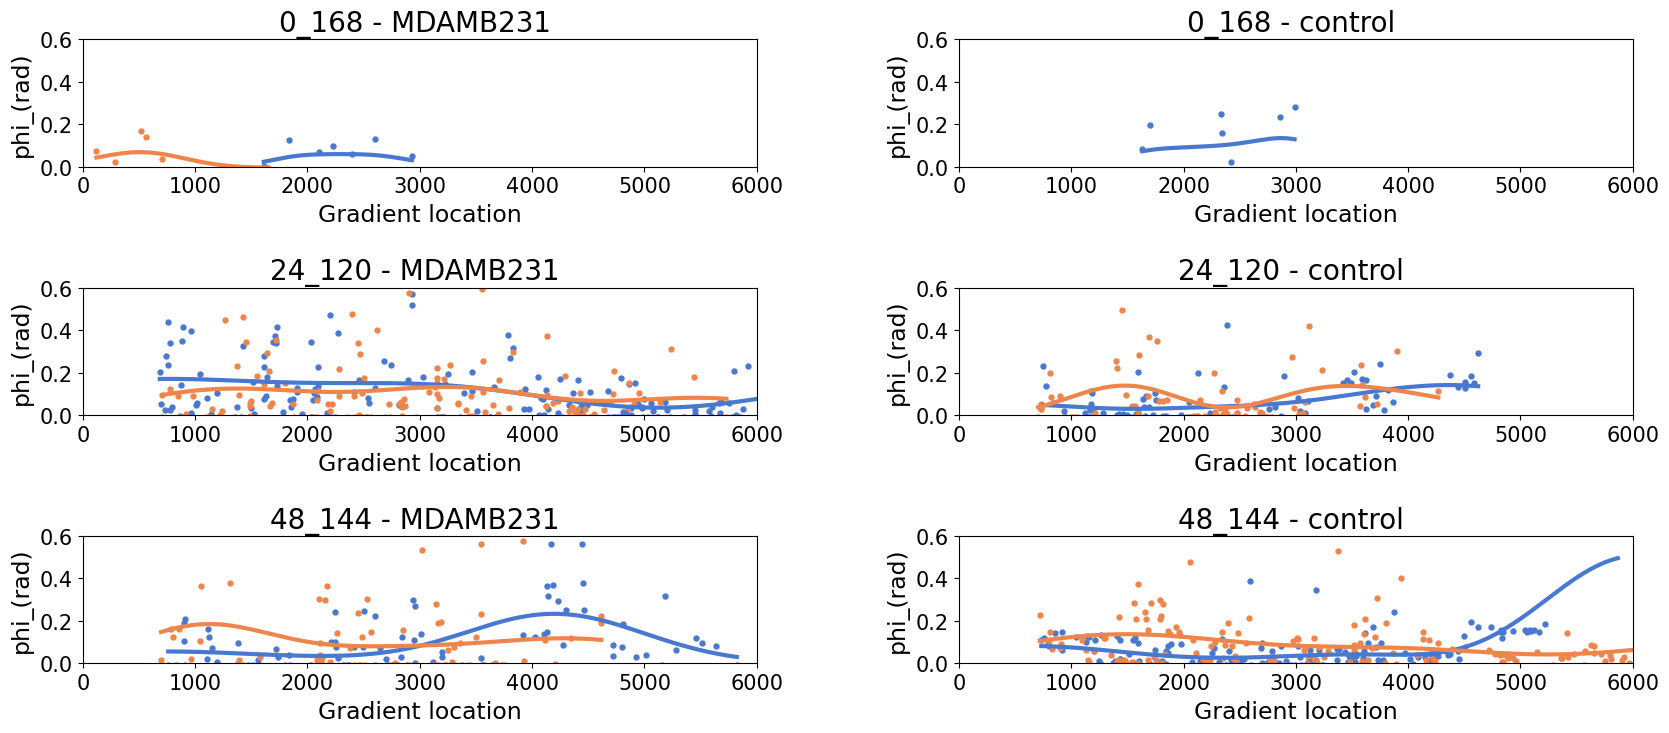

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['phi_(rad)'], ax1, 2, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("phi_(rad)", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0, 0.6)
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


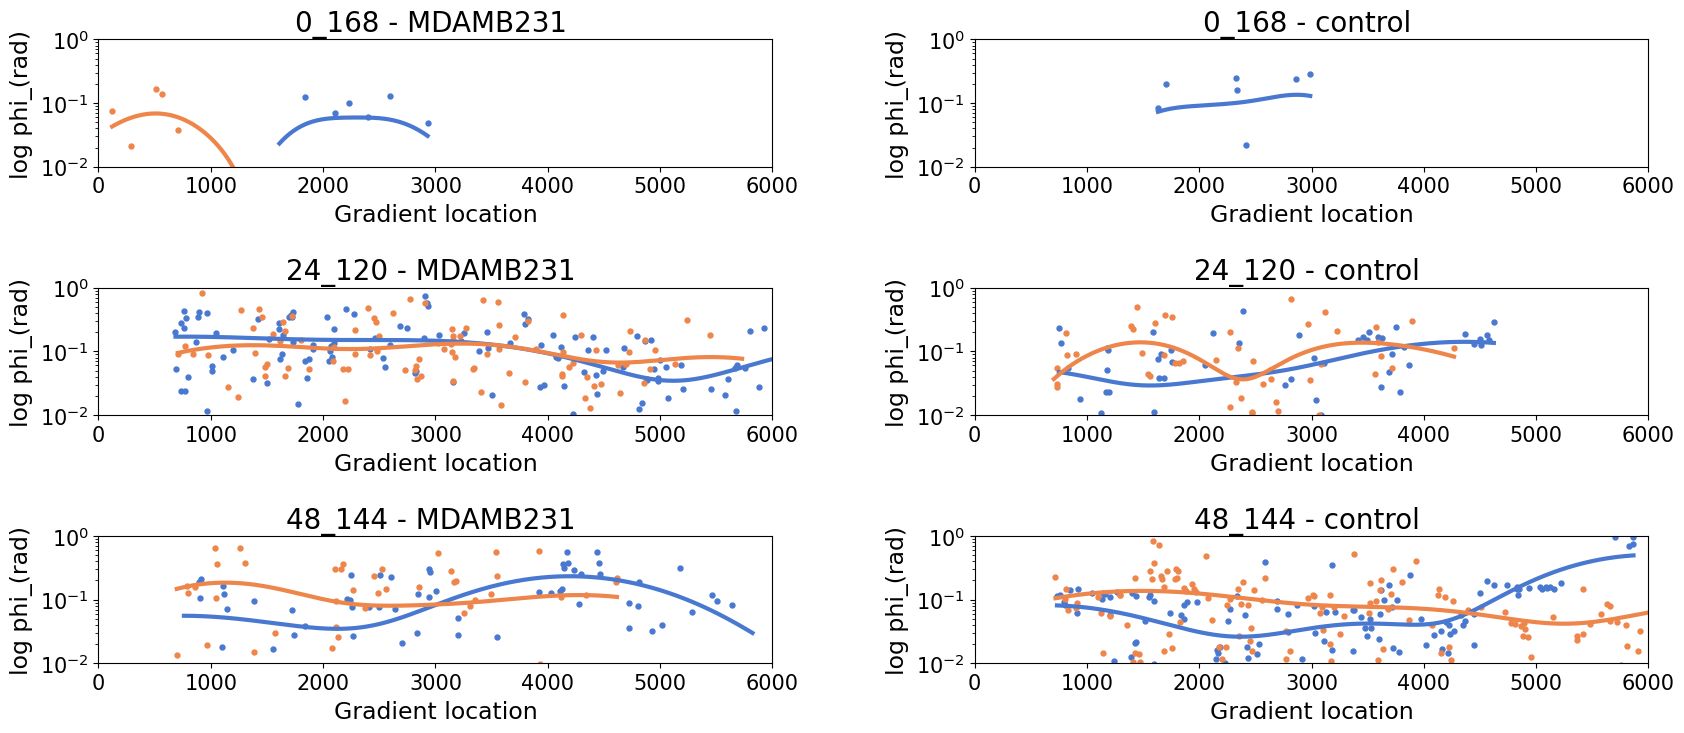

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.95, bottom=0.1) 

colors = final_palette1  

def plotting(grppp, ax1,k,i, incubation):
    if (grppp['gradient_direction'] == 'stiff_to_soft').all():
        x_data = grppp['gradient_inverse']
    else:
        x_data = grppp['gradient']
    countr= (k)
    color = final_palette1[countr]
    fitting_kernel(x_data, grppp['phi_(rad)'], ax1, 2, color, '.')

    ax1.set_xlabel("Gradient location", fontsize=17, labelpad=5)
    ax1.set_ylabel("log phi_(rad)", fontsize=17, labelpad=5)
    ax1.set_title(f"{grppp['incubation_set'].unique()[0]} - {grppp['cell/control'].unique()[0]} ", fontsize=20)

    ax1.tick_params(axis='both', labelsize=15)
    ax1.set_ylim(0.01, 1)
    ax1.set_yscale('log')
    ax1.set_xlim(0, 6000)

    
def plotting_time(grpp, row,i, cell_ctr):
    if cell_ctr[0] == 'MDAMB231':
        col = 0
    elif cell_ctr[0] == 'control':
        col = 1
    else:
        print(f"Warning: Unexpected cell control type '{cell_ctr}'")

    ax1 = axs[row,col]

    for k, (incubation, grppp) in enumerate(grpp.groupby(['incubation'])):
        plotting(grppp, ax1,k,i,incubation)

def filtering_cell_ctr(grp, i):  
    row = i 
    for j, (cell_ctr, grpp) in enumerate(grp.groupby(['cell/control'])):
        plotting_time(grpp, row, i,cell_ctr)

for i, (incubation_set, grp) in enumerate(download.groupby(['incubation_set'])):
    filtering_cell_ctr(grp, i)  

plt.show()


## GLS phase shift

In [93]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha = 0.05

def GLS_phaseshift(data, ax, color):
    # Check for NaNs or infs in input data
    if data['f'].isnull().any() or data['phi_(rad)'].isnull().any():
        print("Data contains NaN values, which might cause issues.")
        return

    if (data['phi_(rad)'] <= 0).any():
        print("Data contains non-positive values in 'phi_(rad)', which will cause issues with log transformation.")
        return

    # Extract x and log-transform y
    x = data['f'].values.reshape(-1, 1)
    y = np.log(data['phi_(rad)'].values)

    # Fit GLS model
    x_const = sm.add_constant(x)
    modelGLS = sm.GLS(y, x_const)
    resultsGSL = modelGLS.fit()

    # Generate predictions
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)
    y_predictedGLS_log = resultsGSL.predict(x_predictedGLS_with_const)
    y_predictedGLS = np.exp(y_predictedGLS_log)

    # Prediction intervals
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)
    y_lower_CI = np.exp(pred_summary['obs_ci_lower'])
    y_upper_CI = np.exp(pred_summary['obs_ci_upper'])

    # Plotting
    ax.scatter(data['f'], data['phi_(rad)'], s=4, c=color, label='Data')
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')
    #ax.fill_between(x_predictedGLS.flatten(), y_lower_CI, y_upper_CI, color=color, alpha=0.1, label='Confidence Interval')
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 5000)
    ax.legend()
    ax.set_xlabel("Frequency (f)")
    ax.set_ylabel("Phase (phi in rad)")

    print("Model fit successfully. Check plot for results.")


OLDER 2024 DATA

In [90]:
paths_old = glob.glob(os.path.join("E:/Turku_collab/microrheometry/2024", "**", "summary_ID_level.csv"), recursive=True)
print(*paths_old, sep='\n')

old_df = []
def parser(i):
    data = pd.read_csv(i)
    data['irradiation'] = (i.split('/')[3].split('\\')[2].split('_')[1])
    data['cell/control'] = (i.split('/')[3].split('\\')[2].split('_')[2])
    data['bead_size'] = (i.split('/')[3].split('\\')[2].split('_')[3])

    
    max_location = data['location'].unique().max()
    data['location_inverse'] = max_location + 1 - data['location']
    data['day'] = (data['day'])
    
    
    for _, location in enumerate(data['location'].unique()):
        data.loc[data['location'] == location, 'gradient'] = data['y'] + location*665.6
        data.loc[data['location'] == location, 'gradient_inverse'] = data['y'] + (max_location-location)*665.6
    return data

old_df = pd.concat([parser(i) for i in paths_old], ignore_index=True)

old_df['day'] = old_df['day'].astype(str)
old_df['gradient_direction'] = np.where(
    (old_df['day'].isin(["240905","240912","240913"])),
    "stiff_to_soft",
    "soft_to_stiff"
)

E:/Turku_collab/microrheometry/2024\240905\240905_50s_control_10um\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240905\240905_50s_MDAMB231_10um\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240912\240913_50s_control_10um\holder_1\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240912\240913_50s_control_10um\holder_2\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240912\240912_70s_MDAMB231_mix\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240912\240912_50s_MDAMB231_mix\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240913\240913_50s_control_10um\holder_1\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240913\240913_50s_control_10um\holder_2\results\summary_ID_level.csv
E:/Turku_collab/microrheometry/2024\240823\240823_50s_control_30um\results\summary_ID_level.csv


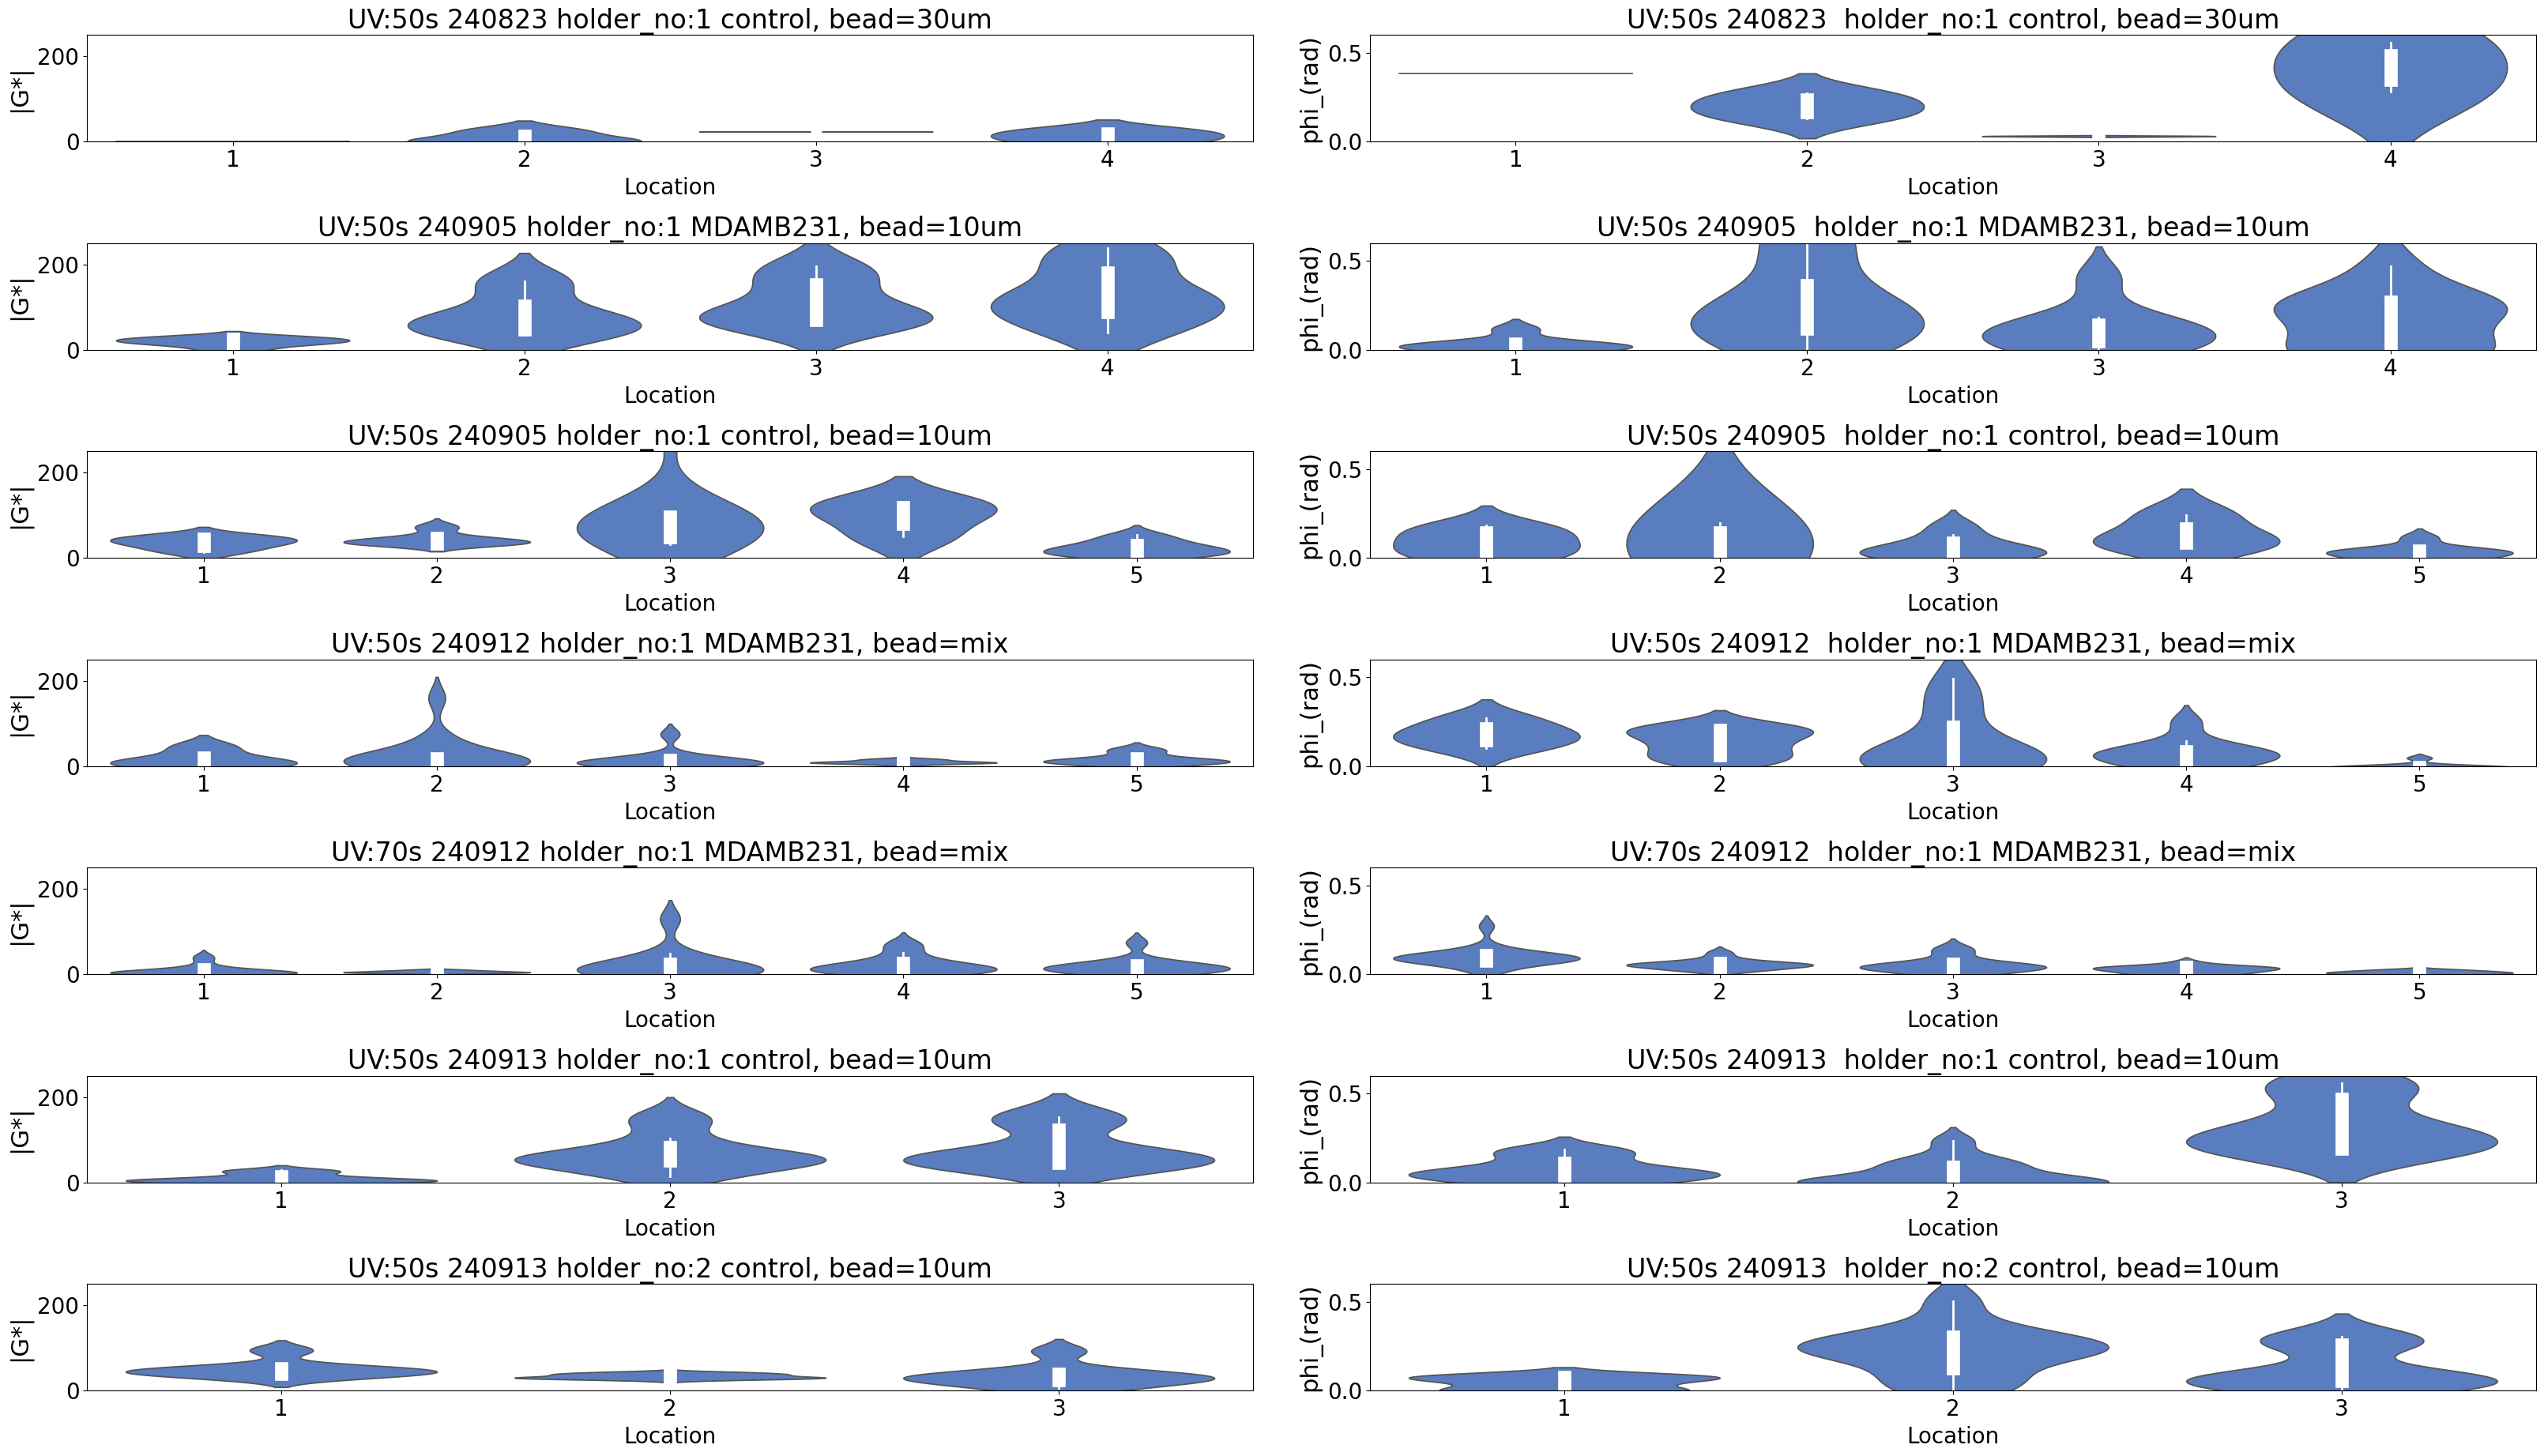

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the subplots
fig, axs = plt.subplots(7, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("", fontsize=22)

markers = ['x', 's']
pal = sns.color_palette("muted", 1)[0]  

def plotting(data, i, day, holder, irradiation, cell_control):
    bead = data['bead_size'].unique()[0]
    if (data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = data['location_inverse']
    else:
        x_data = data['location']

    ax1 = axs[i, 0] 
    sns.violinplot(x=x_data, y='G_abs', data=data, 
                   inner='box', width=0.8, 
                   density_norm='width', ax=ax1, 
                   inner_kws=dict(box_width=12, whis_width=2, color="1"), 
                   color=pal) 
        
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=22, labelpad=5)
    ax1.set_title(f"UV:{irradiation} {day} holder_no:{holder} {cell_control}, bead={bead}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.set_ylim(0,250)

    ax2 = axs[i, 1]
    sns.violinplot(x=x_data, y='phi_(rad)', data=data, 
                   inner='box', width=0.8, 
                   density_norm='width', ax=ax2, 
                   inner_kws=dict(box_width=12, whis_width=2, color="1"), 
                   color=pal)
                   
    ax2.set_xlabel("Location", fontsize=20, labelpad=5)
    ax2.set_ylabel("phi_(rad)", fontsize=22, labelpad=5)
    ax2.set_title(f"UV:{irradiation} {day}  holder_no:{holder} {cell_control}, bead={bead}", fontsize=24)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.set_ylim(0, 0.6)
    
for i, ((day, holder, irradiation, cell_control), group_data) in enumerate(old_df.groupby(['day', 'holder', 'irradiation', 'cell/control'])):
    plotting(group_data, i, day, holder, irradiation, cell_control)


plt.show()


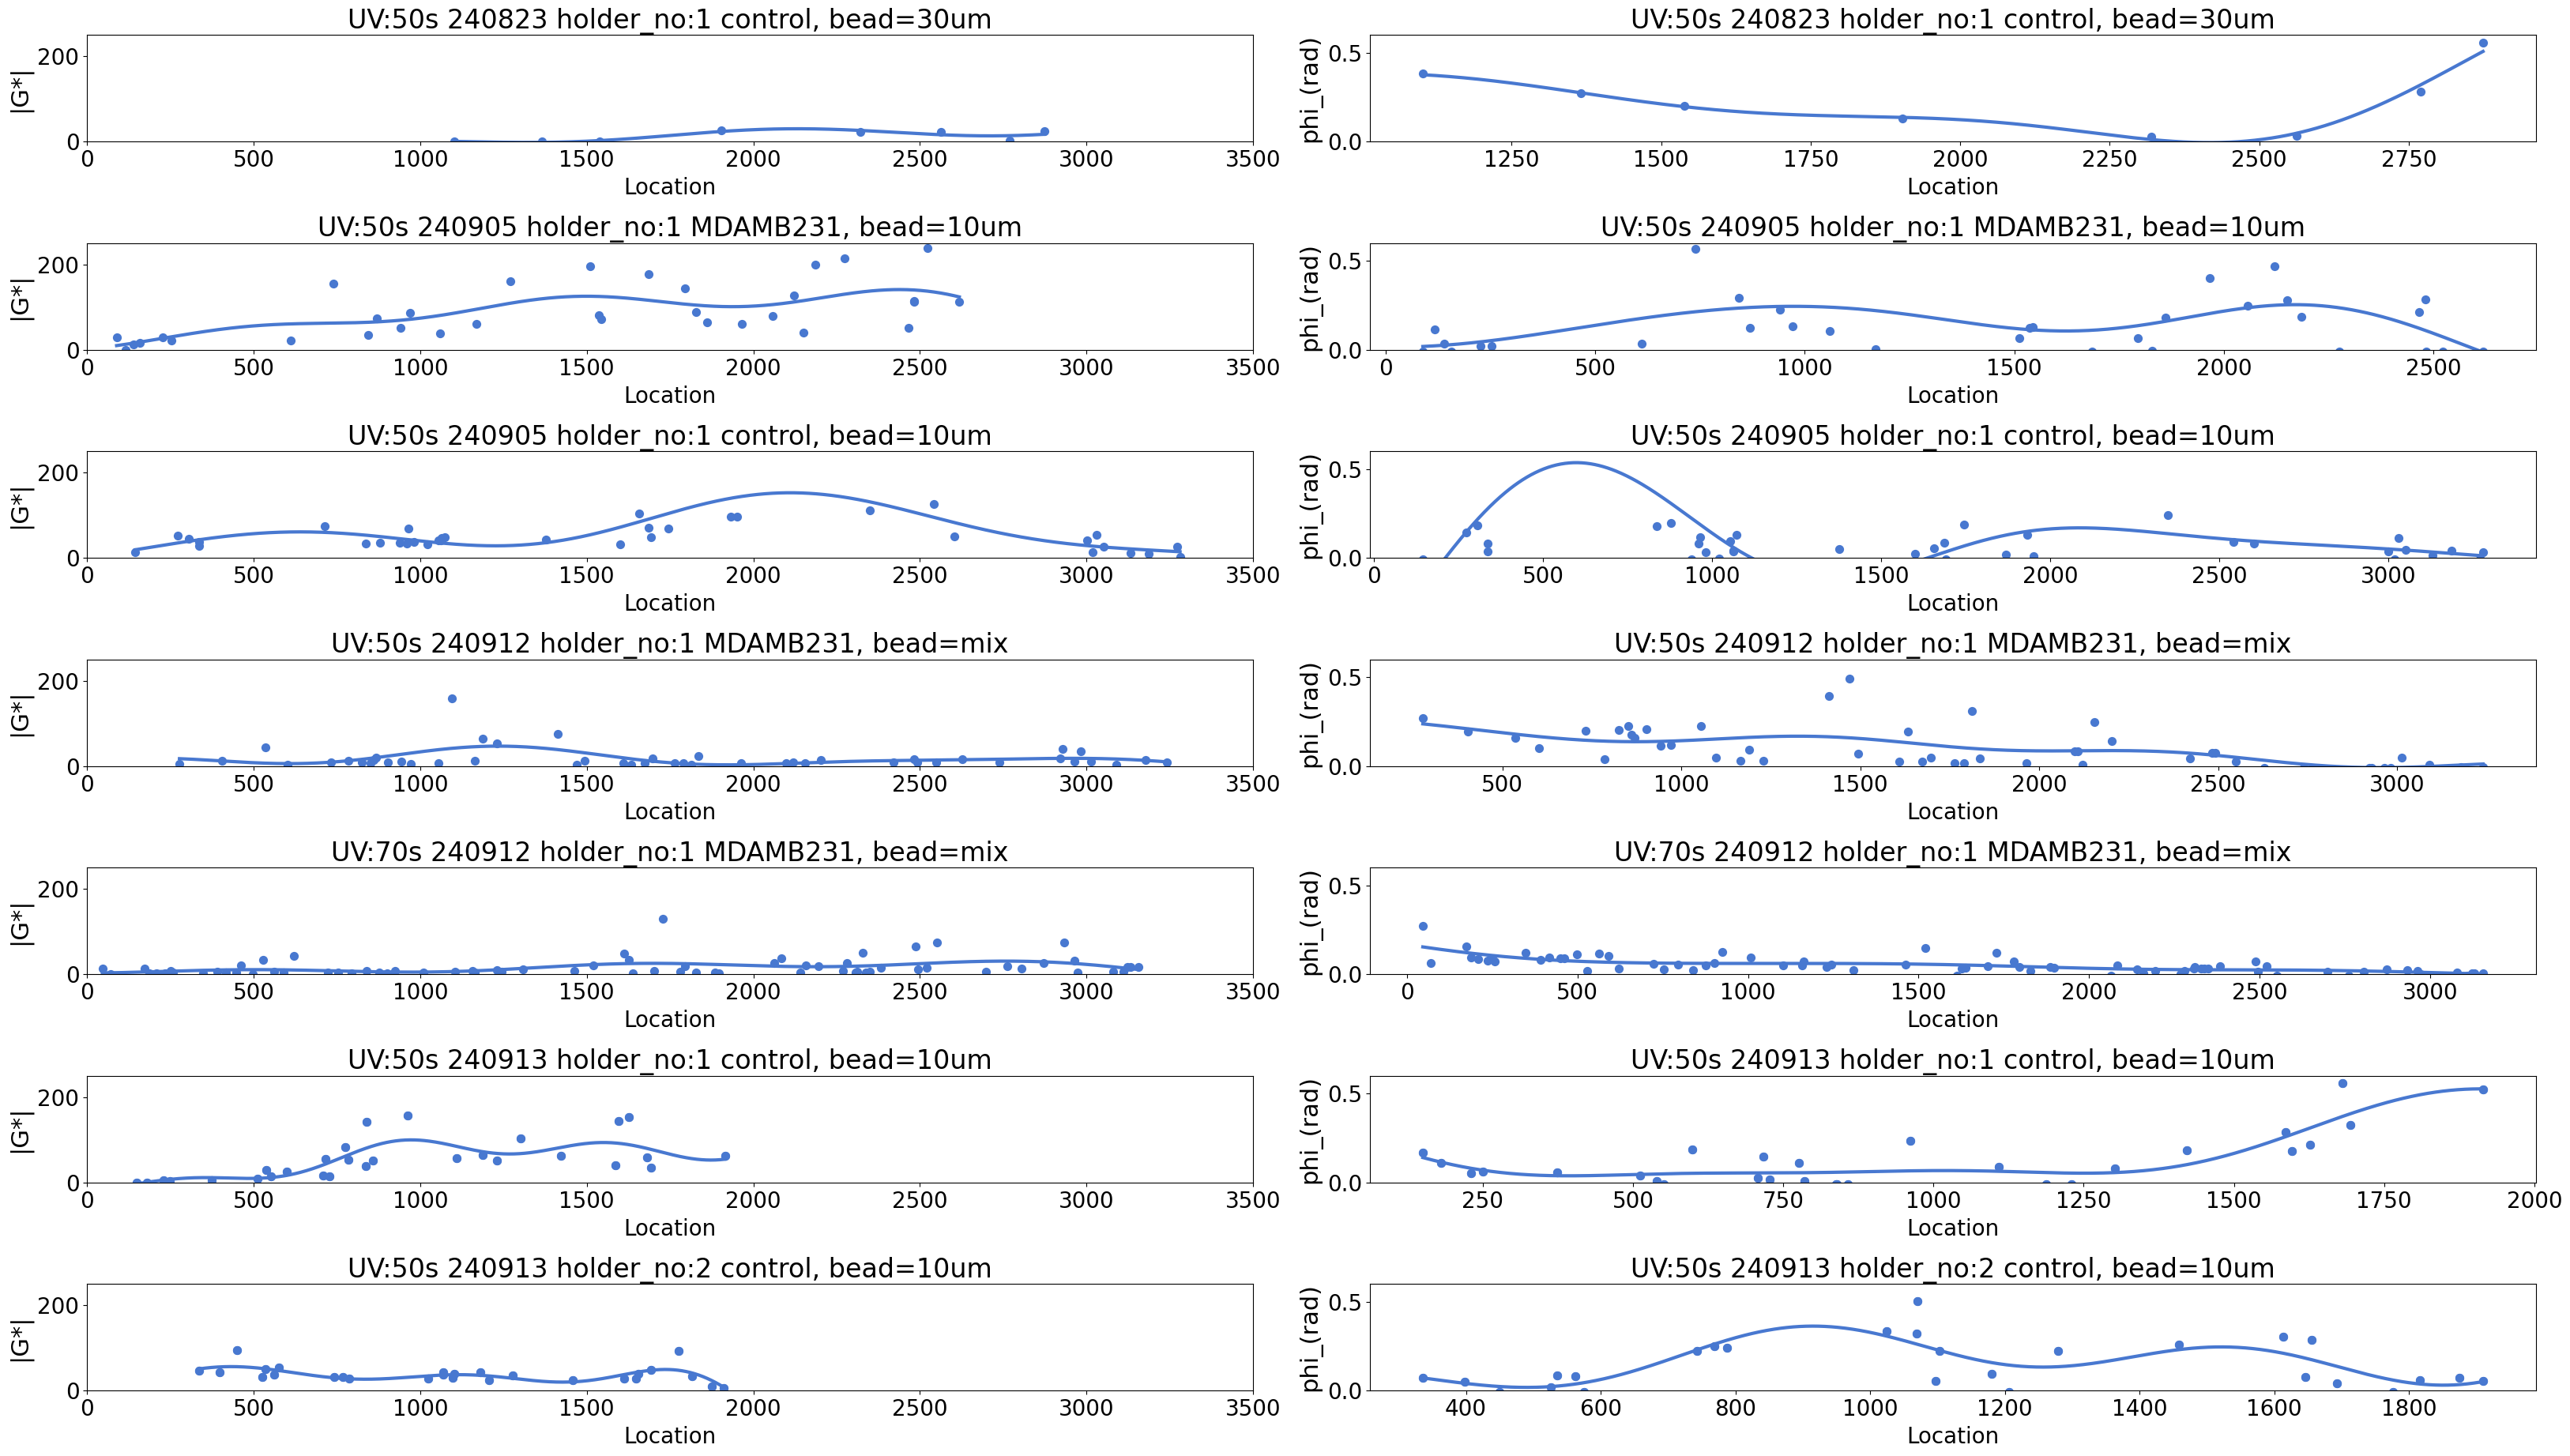

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

def fitting_kernel_bin(x, y, ax,alpha, color):
    x_reshaped = x.values.reshape(-1, 1)  #     # Reshape x to a 2D array (required for scikit-learn models), converts x into a 2D array with shape (n_samples, 1)
    y_reshaped = y.values 
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_reshaped) 
    
    # Initialize Kernel Ridge Regression model
    # similarity between two points in higher-dimensional space = this is done using a kernel function, here Radial Basis Function (RBF) kernel
    # ALPHA = regularization factor
    krr = KernelRidge(kernel='rbf', alpha=alpha)  # A larger --> more regularization; model prioritizes simpler solutions fitting general trend and not capture smaller details
    # Fit the model with the given data
    krr.fit(x_scaled, y_reshaped)

    # Grid of x values for the kernel fit (scaled)
    x_fit = np.linspace(np.min(x_scaled), np.max(x_scaled), 1000)[:, np.newaxis]  # Fine grid for prediction
    y_fit = krr.predict(x_fit)  # Predict the y values for the fine grid

    # Rescale x_fit back to original scale for plotting
    x_fit_original = scaler.inverse_transform(x_fit)  # Rescale the x values back

    # Plot the original data as a scatter plot
    ax.scatter(x_reshaped, y_reshaped, label='Original Data', color=color,s=50)
    
    #ax.boxplot(x_reshaped, y_reshaped, label='Original Data')

    # Plot the kernel fit (the kernel regression curve)
    ax.plot(x_fit_original, y_fit,color=color, label='Kernel Fit', linewidth=3)

# Create subplots
fig, axs = plt.subplots(7, 2, figsize=(40, 22))
plt.subplots_adjust(wspace=0.1, hspace=0.95, bottom=0.1)  # Adjust bottom to make space for the legend
fig.suptitle("", fontsize=22)

# Choose the first color from the "muted" palette
pal = sns.color_palette("muted", 1)[0]  

def plotting(data, i, day, holder, irradiation, cell_control, alpha=1e-2):
    bead = data['bead_size'].unique()[0]

    if (data['gradient_direction'] == 'stiff_to_soft').all():
        x_data = data['gradient_inverse']
    else:
        x_data = data['gradient']


    # Plot for G_abs
    ax1 = axs[i, 0] 
    # sns.violinplot(x=x_data, y='G_abs', data=data, 
    #                inner='box', width=0.8, 
    #                density_norm='width', ax=ax1, legend=True, 
    #                inner_kws=dict(box_width=12, whis_width=2, color="1"), 
    #                color=pal) 
    fitting_kernel_bin(x_data, data['G_abs'], ax1, alpha, pal)  # Add the kernel regression line
        
    ax1.set_xlabel("Location", fontsize=20, labelpad=5)
    ax1.set_ylabel("|G*|", fontsize=22, labelpad=5)
    ax1.set_title(f"UV:{irradiation} {day} holder_no:{holder} {cell_control}, bead={bead}", fontsize=24)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.legend().remove()
    ax1.set_ylim(0,250)
    ax1.set_xlim(0,3500)


    # Plot for phi_(rad)
    ax2 = axs[i, 1]
    # sns.violinplot(x=x_data, y='phi_(rad)', data=data, 
    #                inner='box', width=0.8, 
    #                density_norm='width', ax=ax2, legend=True, 
    #                inner_kws=dict(box_width=12, whis_width=2, color="1"), 
    #                color=pal) 
    fitting_kernel_bin(x_data, data['phi_(rad)'], ax2, alpha, pal)  # Add the kernel regression line

    ax2.set_xlabel("Location", fontsize=20, labelpad=5)
    ax2.set_ylabel("phi_(rad)", fontsize=22, labelpad=5)
    ax2.set_title(f"UV:{irradiation} {day} holder_no:{holder} {cell_control}, bead={bead}", fontsize=24)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.legend().remove()
    ax2.set_ylim(0, 0.6)
    ax1.set_xlim(0,3500)


# Assuming `old_df` is your DataFrame
for i, ((day, holder, irradiation, cell_control), group_data) in enumerate(old_df.groupby(['day', 'holder', 'irradiation', 'cell/control'])):
    plotting(group_data, i, day, holder, irradiation, cell_control)

plt.show()
